Teamnaam: Ongeneeselijk dakloos

Teamleden:
1. needanku (Tijn)
2. jipschijvenaars (Jip)
3. joesvandeursen (Joes)
4. jimaugustinus (Jim)


## Importeren libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.fft import fft
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Fourier analysis
from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose

#Regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse

#metrics and CV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, KFold
import math

In [31]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

display(train_data.head(5))
display(test_data.head(5))

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896


# Opdracht 1: Exploratieve Data Analyse

In [32]:
display(train_data.dtypes)
display(train_data.describe())

date_hour      object
holiday         int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


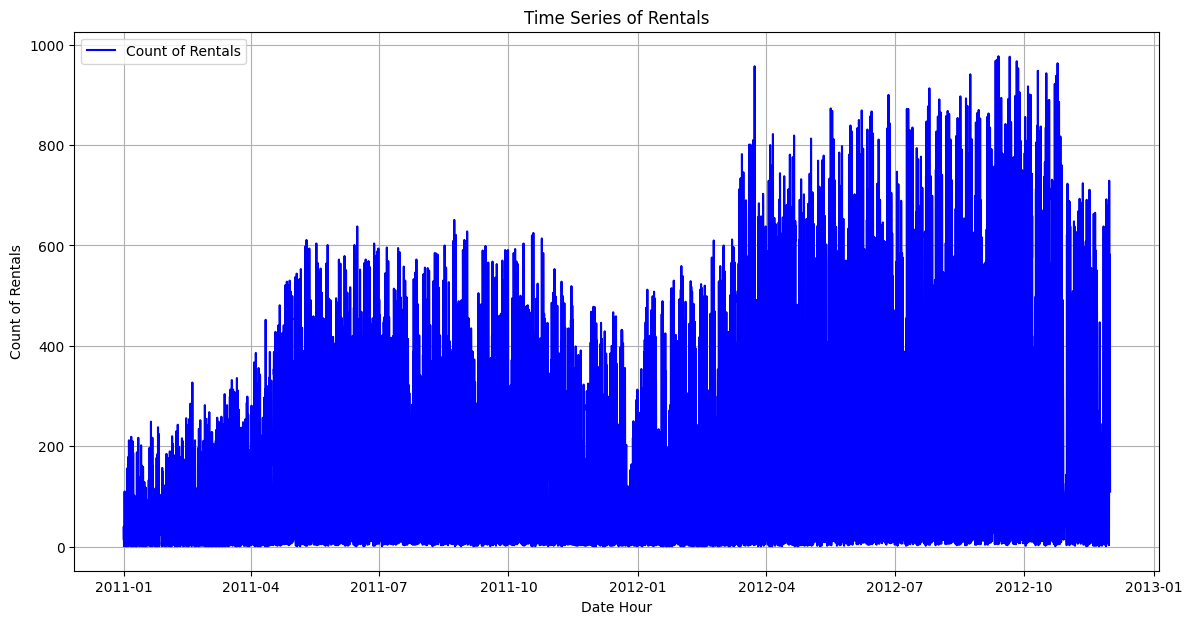

In [33]:
train_data['date_hour'] = pd.to_datetime(train_data['date_hour'])

train_data.set_index('date_hour', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['cnt'], color='blue', label='Count of Rentals')
plt.title('Time Series of Rentals')
plt.xlabel('Date Hour')
plt.ylabel('Count of Rentals')
plt.legend()
plt.grid()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_38816\863123823.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data, x='weathersit', y='cnt', palette='Set2')


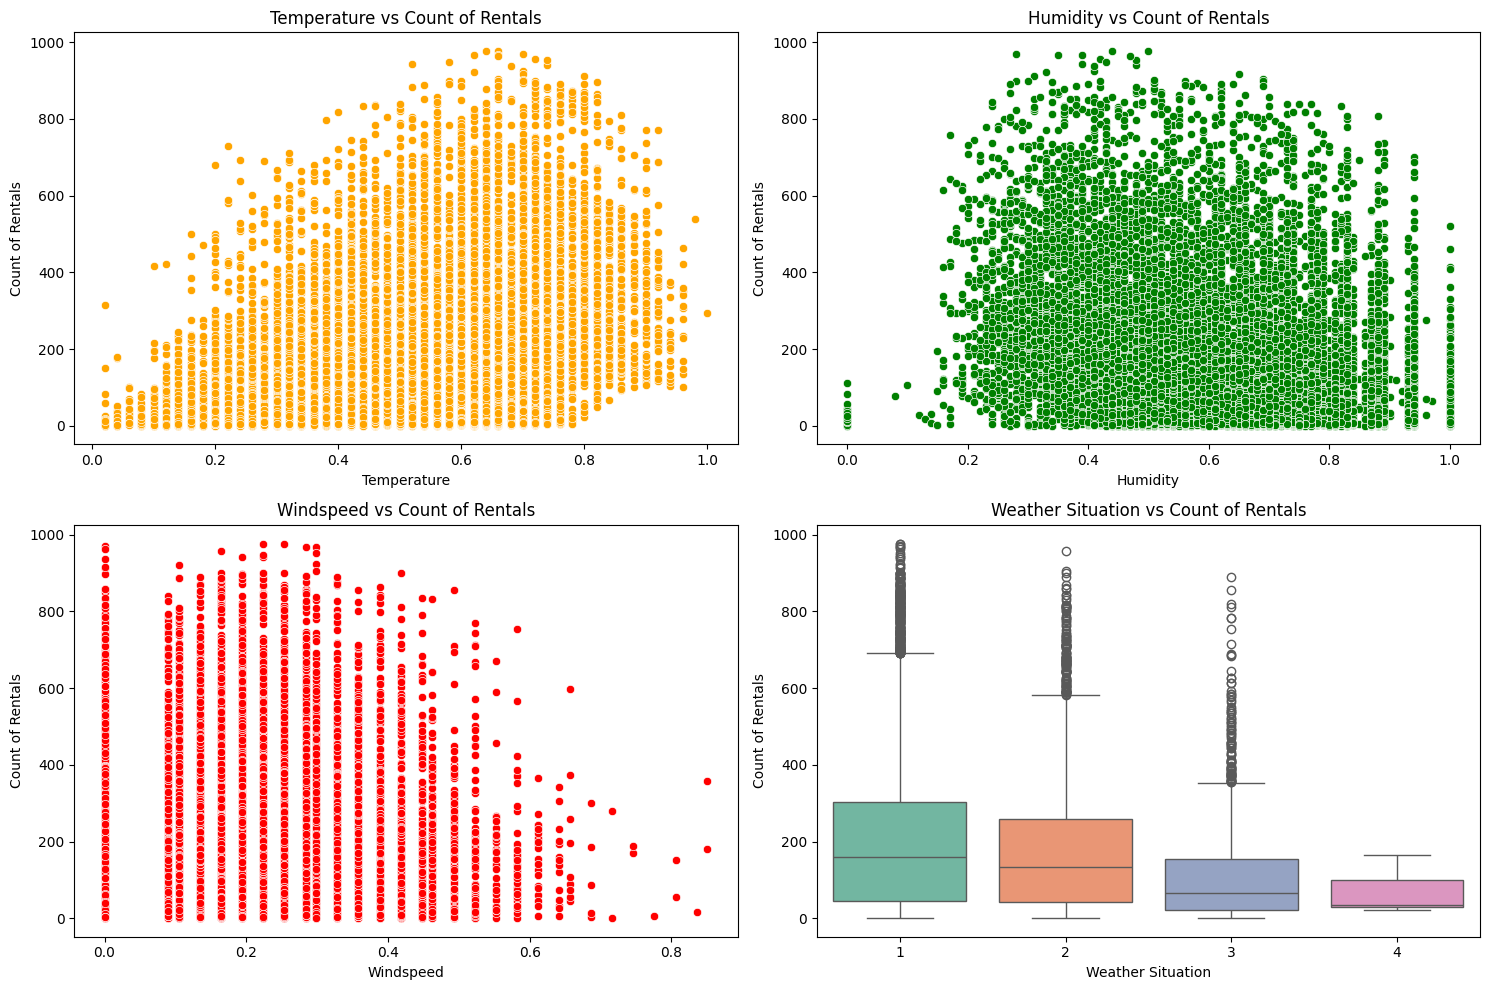

In [34]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(data=train_data, x='temp', y='cnt', color='orange')
plt.title('Temperature vs Count of Rentals')
plt.xlabel('Temperature')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 2)
sns.scatterplot(data=train_data, x='hum', y='cnt', color='green')
plt.title('Humidity vs Count of Rentals')
plt.xlabel('Humidity')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 3)
sns.scatterplot(data=train_data, x='windspeed', y='cnt', color='red')
plt.title('Windspeed vs Count of Rentals')
plt.xlabel('Windspeed')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 4)
sns.boxplot(data=train_data, x='weathersit', y='cnt', palette='Set2')
plt.title('Weather Situation vs Count of Rentals')
plt.xlabel('Weather Situation')
plt.ylabel('Count of Rentals')

plt.tight_layout()
plt.show()

1. De tijdrijgrafiek laat zien dat verhuur duidelijke seizoenspatronen heeft, met pieken tijdens bepaalde periodes van het jaar.  
2. Er is een positieve correlatie tussen temperatuur en het aantal verhuur, wat suggereert dat hogere temperaturen leiden tot meer verhuur.  
3. Luchtvochtigheid lijkt een negatief effect te hebben op verhuur; naarmate de luchtvochtigheid toeneemt, neemt het aantal verhuurd af.  
4. Windsnelheid toont een zwakke negatieve correlatie met verhuur, wat erop wijst dat hogere windsnelheden gebruikers kunnen ontmoedigen om te huren.  
5. De boxplot voor weersituatie laat zien dat bepaalde weersomstandigheden (zoals helder of licht bewolkt) geassocieerd zijn met hogere aantallen verhuur in vergelijking met andere omstandigheden (zoals regen of sneeuw).  


### Data cleaning

In [35]:
missing_values = train_data.isnull().sum()
duplicates = train_data.duplicated().sum()

print('Missing Values per Column:')
print(missing_values)
print(f'Total Duplicates: {duplicates}')

Missing Values per Column:
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64
Total Duplicates: 106


Er zijn geen missende waarden, wel zijn er 106 dubbele rijen. Door deze te verwijderen maken we de dataset uniek en consistent.

In [36]:
train_data_cleaned = train_data.drop_duplicates()
cleaned_shape = train_data_cleaned.shape

print(f'Original shape: {train_data.shape}')
print(f'Cleaned shape: {cleaned_shape}')

Original shape: (16637, 7)
Cleaned shape: (16531, 7)


### Relevantie bepalen

<Axes: >

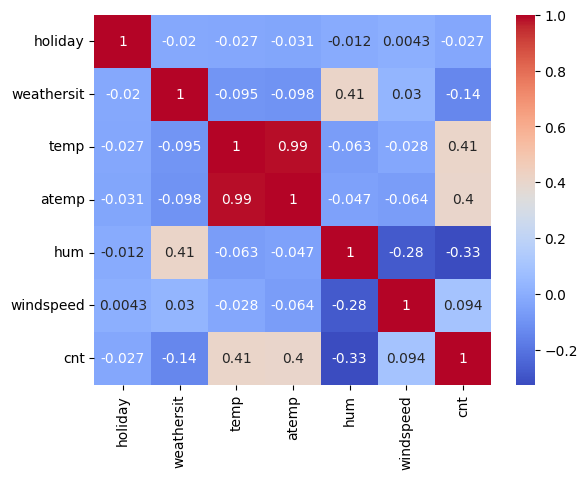

In [37]:
correlation_matrix = train_data_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

- We berekenen de correlatie om te zien welke gegevens belangrijk kunnen zijn.
- We kiezen de kolommen die nuttig zijn.
- We maken een kleinere, overzichtelijke dataset waarmee je verder kunt werken.

# Opdracht 2: Time series feature engineerin

In [38]:
train_data_final = train_data_cleaned.copy()

In [ ]:
train_data_final['year'] = train_data_final.index.year
train_data_final['month'] = train_data_final.index.month
train_data_final['day'] = train_data_final.index.day
train_data_final['day_of_week'] = train_data_final.index.dayofweek
train_data_final['quarter'] = train_data_final.index.quarter

train_data_final['sin_month'] = np.sin(2 * np.pi * train_data_final['month'] / 12)
train_data_final['cos_month'] = np.cos(2 * np.pi * train_data_final['month'] / 12)

train_data_final.head()


,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,day_of_week,quarter,sin_month,cos_month
date_hour,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,1,5,1,0.5,0.866025
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,1,5,1,0.5,0.866025
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,1,5,1,0.5,0.866025
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,1,5,1,0.5,0.866025
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,1,5,1,0.5,0.866025


We voegen extra kolommen toe aan onze dataset om meer informatie uit de datum-index te halen. Deze extra gegevens kunnen ons helpen om patronen en trends beter te begrijpen en ons model te verbeteren.

We halen het jaar, maand, dag, dag van de week en het kwartaal uit de datum-index:
- Zo kunnen we analyseren of er bepaalde trends zijn die te maken hebben met tijd.

Seizoenspatronen toevoegen met sinus en cosinus:
- We gebruiken de maand en zetten deze om in sinus- en cosinuswaarden. Dit is handig om seizoensgebonden patronen te modelleren, zoals veranderingen door de tijd heen.
- Door sinus en cosinus te gebruiken, geven we onze dataset een cyclische structuur: januari (maand 1) en december (maand 12) liggen hierdoor dicht bij elkaar, wat logischer is voor maandelijkse trends.

## Fourier Analyse

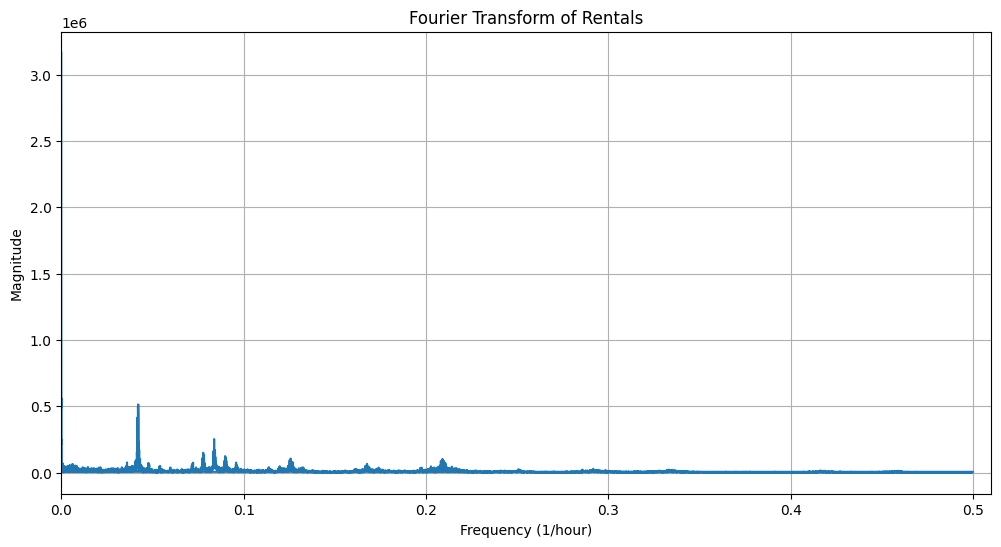

In [41]:
cnt_values = train_data_cleaned['cnt'].values

fourier_transform = fft(cnt_values)

n = len(cnt_values)
frequencies = np.fft.fftfreq(n)

plt.figure(figsize=(12, 6))
plt.plot(frequencies, np.abs(fourier_transform))
plt.title('Fourier Transform of Rentals')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Magnitude')
plt.xlim(0, 0.51)
plt.grid()
plt.show()

Piek rond 0.04:
- Dit suggereert een belangrijke cyclische trend. Als we dit om rekenen naar uren krijgen we 1/0.04 = 25. Omdat de exacte waarde moeilijk af te lezen is het waarschijnlijker dat dit over 24 uur gaat, een hele dag. In de data is er dus een dagelijks patroon aanwezig.

Andere pieken:
- Er zijn kleinere pieken op andere frequenties tussen de 0.07 en 0.09. Dit wijst op minder sterke terugkerende patronen.

Hobbels:
- Er zijn nog een paar hobbels te zien, maar deze hebben een te lage magnitude om relevant te zijn.

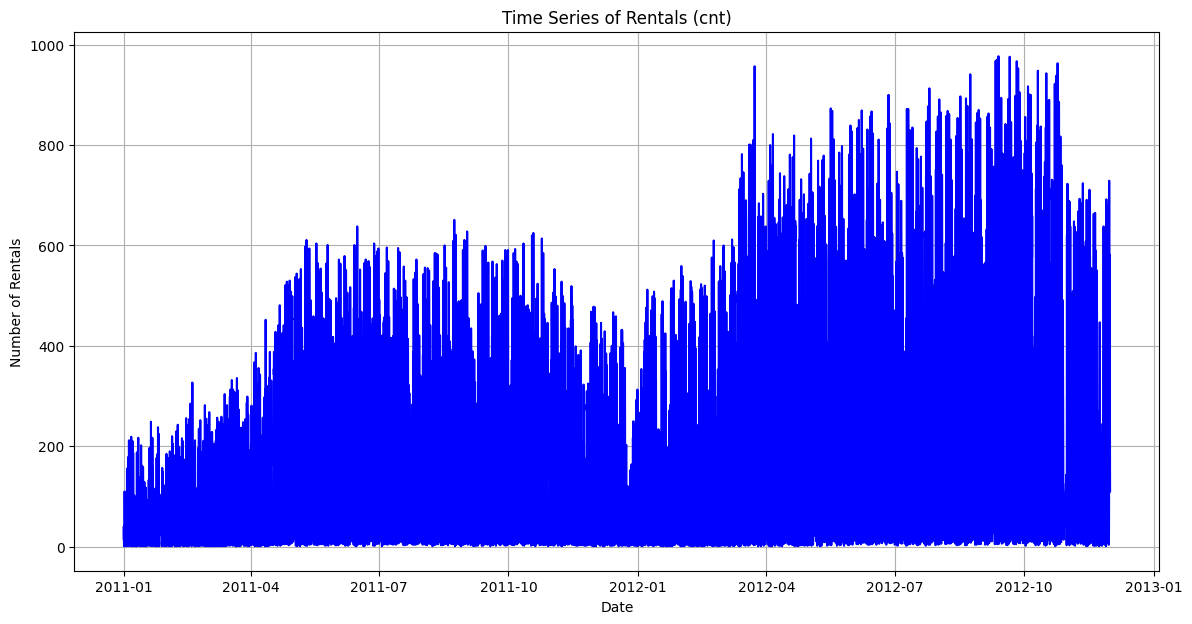

In [42]:
plt.figure(figsize=(14, 7))
plt.plot(train_data_final.index, train_data_final['cnt'], color='blue')
plt.title('Time Series of Rentals (cnt)')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.grid()
plt.show()

### Seizoensgebonden trends:
- In de lente en zomer (rond het midden van 2011 en 2012) zie je een duidelijke toename in het aantal verhuur. Dit kan worden toegeschreven aan het betere weer in die perioden.
- In de herfst en winter (eind 2011 en 2012) zie je een daling, waarschijnlijk door kouder weer en minder gunstige weersomstandigheden voor verhuren.

### Langzame groei in 2011:
- Het aantal verhuur stijgt geleidelijk in het eerste jaar (2011). Dit kan te maken hebben met een groeiende populariteit of uitbreiding van de verhuurdienst.

### Schommelingen:
- Je ziet dagelijkse of wekelijkse pieken en dalen. Mogelijk zijn dit weekdagen versus weekends, waarbij verhuur in het weekend hoger is.

### Sterkere verhuur in 2012:
- In 2012 lijkt het gemiddeld aantal verhuur per dag hoger te liggen dan in 2011.

### Seizoenspiek in de zomer:
- De hoogste waarden (bijvoorbeeld in de zomer van 2012) wijzen op maximale drukte in die periode.


## ACF

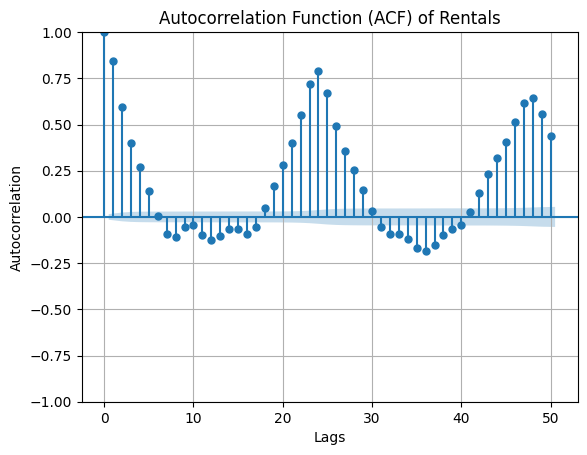

In [43]:
# Er is voor een lag van 50 gekozen omdat dit het patroon per dag duidelijk zichtbaar maakt.
plot_acf(train_data_cleaned['cnt'], lags=50)
plt.title('Autocorrelation Function (ACF) of Rentals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

De ACF meet hoe sterk de waarde van het aantal verhuur op een specifieke dag (de "lag 0") correleert met de waarden van eerdere dagen (bijvoorbeeld "lag 1", "lag 2", enz.). Dit helpt ons patronen in de tijdreeksen te begrijpen.

- Ook hier is er een patroon van 24 uur te herkennen.

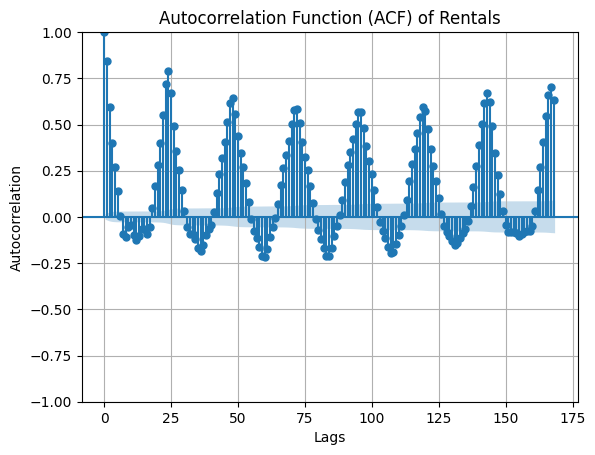

In [44]:
# lag van 168 is gekozen omdat dit een week is in uren.
plot_acf(train_data_cleaned['cnt'], lags=168)
plt.title('Autocorrelation Function (ACF) of Rentals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

Als we kijken naar de autocorrelatie met een lag van 168 (1 week) kunnen we het dagelijkse partoon duidelijk terug zien. We zien ook dat niet alle pieken even hoog zijn. Wat ook opvalt is dat de piek iets hoger is na zeven dagen, dit kan betekenen dat sommige dagen drukker zijn dan andere. Er kan bijvoorbeeld een verschil zijn tussen de hoeveelheid verhuur op week- of weekenddagen.

## Trend toevoegen en visualiseren

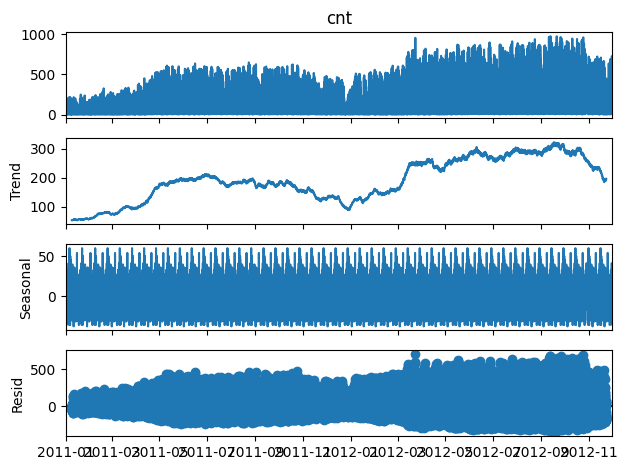

In [45]:
decomposition = seasonal_decompose(train_data_final['cnt'], model='additive', period=365)

train_data_final['trend'] = decomposition.trend
train_data_final['seasonal'] = decomposition.seasonal
train_data_final['residual'] = decomposition.resid

decomposition.plot()
plt.show()

- Trend: Het laat een duidelijke stijging en daling zien, wat overeenkomt met veranderingen in de tijd.
- Seasonal: Dit patroon herhaalt zich consistent en is dus ideaal voor het modelleren van seizoensgebonden effecten in de testset.
- Residuals: Dit is ruis of onverwachte variabiliteit. Dit is nuttig voor foutanalyse maar niet bruikbaar voor extrapolatie.

## Time Series Feature Engineering

In [47]:
train_data_final['is_weekend'] = train_data_final['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
train_data_final['season'] = train_data_final['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')
train_data_final['is_spring'] = train_data_final['season'].apply(lambda x: 1 if x == 'spring' else 0)
train_data_final['is_summer'] = train_data_final['season'].apply(lambda x: 1 if x == 'summer' else 0)
train_data_final['is_autumn'] = train_data_final['season'].apply(lambda x: 1 if x == 'autumn' else 0)
train_data_final['is_winter'] = train_data_final['season'].apply(lambda x: 1 if x == 'winter' else 0)

train_data_final['temp_atemp_diff'] = train_data_final['temp'] - train_data_final['atemp']
train_data_final['hum_windspeed_interaction'] = train_data_final['hum'] * train_data_final['windspeed']

train_data_final['sin_day_of_week'] = np.sin(2 * np.pi * train_data_final['day_of_week'] / 7)
train_data_final['cos_day_of_week'] = np.cos(2 * np.pi * train_data_final['day_of_week'] / 7)

train_data_final['is_month_end'] = train_data_final['day'] >= 25


train_data_final['temp_month_rel'] = train_data_final['temp'] / train_data_final.groupby('month')['temp'].transform('mean')
train_data_final['hum_month_rel'] = train_data_final['hum'] / train_data_final.groupby('month')['hum'].transform('mean')

train_data_final['is_heatwave'] = train_data_final['temp'] > 30
train_data_final['is_storm'] = train_data_final['windspeed'] > 40

train_data_final['windspeed_change'] = train_data_final['windspeed'] - train_data_final['windspeed'].shift(1)

train_data_final['temp_diff_from_max'] = train_data_final['temp'] - train_data_final.groupby('month')['temp'].transform('max')
train_data_final['temp_windspeed_interaction'] = train_data_final['temp'] * train_data_final['windspeed']

train_data_final['lagged_temp'] = train_data_final['temp'].shift(1)
train_data_final['lagged_hum'] = train_data_final['hum'].shift(1)
train_data_final['lagged_weathersit'] = train_data_final['weathersit'].shift(1)


display(train_data_final.head())
display(train_data_final.columns)
display(train_data_final.shape)

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,...,temp_month_rel,hum_month_rel,is_heatwave,is_storm,windspeed_change,temp_diff_from_max,temp_windspeed_interaction,lagged_temp,lagged_hum,lagged_weathersit
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,1,...,1.009120,1.393759,False,False,NaN,-0.34,0.0,NaN,NaN,NaN
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,1,...,0.925027,1.376553,False,False,0.0,-0.36,0.0,0.24,0.81,1.0
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,1,...,0.925027,1.376553,False,False,0.0,-0.36,0.0,0.22,0.80,1.0
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,1,...,1.009120,1.290518,False,False,0.0,-0.34,0.0,0.22,0.80,1.0
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,1,...,1.009120,1.290518,False,False,0.0,-0.34,0.0,0.24,0.75,1.0


Index(['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month',
       'cos_month', 'trend', 'seasonal', 'residual', 'is_weekend', 'season',
       'is_spring', 'is_summer', 'is_autumn', 'is_winter', 'temp_atemp_diff',
       'hum_windspeed_interaction', 'sin_day_of_week', 'cos_day_of_week',
       'is_month_end', 'temp_month_rel', 'hum_month_rel', 'is_heatwave',
       'is_storm', 'windspeed_change', 'temp_diff_from_max',
       'temp_windspeed_interaction', 'lagged_temp', 'lagged_hum',
       'lagged_weathersit'],
      dtype='object')

(16531, 38)

## Uitleg van Toegevoegde Kenmerken

### Tijdsgebaseerde Kenmerken
- **`is_weekend`**  
  Geeft aan of het een zaterdag of zondag is (`1`) of niet (`0`).

- **`season`**  
  Verdeelt de maanden in winter, lente, zomer en herfst:  
  - Extra kolommen zoals `is_spring`, `is_summer`, enz., markeren of een datum in dat seizoen valt (`1`) of niet (`0`).  
  - Dit helpt bij het modelleren van seizoensinvloeden.

### Weergerelateerde Kenmerken
- **`temp_atemp_diff`**  
  Kijkt naar het verschil tussen de gemeten en gevoelstemperatuur.

- **`hum_windspeed_interaction`**  
  Combineert luchtvochtigheid en windsnelheid, wat weersomstandigheden beter samenvat.

### Cyclische Patronen
- **`sin_day_of_week` en `cos_day_of_week`**  
  Leggen vast dat dagen van de week een cyclisch patroon volgen (bijvoorbeeld maandag komt na zondag).

### Relaties met Maandgemiddelden
- **`temp_month_rel` en `hum_month_rel`**  
  Tonen hoe temperatuur en luchtvochtigheid zich verhouden tot het maandgemiddelde.

### Bijzondere Dagen
- **`is_heatwave`**  
  Markeert dagen met een temperatuur boven 30 graden.

- **`is_month_end`**  
  Geeft aan of een dag in de laatste week van de maand valt.

### Veranderingen en Interacties
- **`windspeed_change`**  
  Kijkt naar de verandering in windsnelheid vergeleken met de vorige dag.

- **`temp_diff_from_max`**  
  Vergelijkt de temperatuur met de hoogste temperatuur die maand.

- **`temp_windspeed_interaction`**  
  Combineert temperatuur en windsnelheid, wat een invloed kan hebben op verhuur.

### Lagged Kenmerken
- **`lagged_temp`, `lagged_hum`, en `lagged_weathersit`**  
  Gebruiken waarden van de vorige dag om te zien of recente trends een invloed hebben.


## EDA 

Door het toevoegen van een groot aantal tijdfeatures kan er veel veranderd zijn in hoe de data eruit ziet. Hierom is het noodzakelijk om een tweede EDA uit te voeren. 

In [48]:
display(train_data_final.dtypes.value_counts())

display(train_data_final.describe())

object_cols = train_data_final.select_dtypes(include=['object'])

display(object_cols)

float64    21
int64       8
int32       5
bool        3
object      1
Name: count, dtype: int64

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,...,sin_day_of_week,cos_day_of_week,temp_month_rel,hum_month_rel,windspeed_change,temp_diff_from_max,temp_windspeed_interaction,lagged_temp,lagged_hum,lagged_weathersit
count,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,...,16531.000000,16531.000000,16531.000000,16531.000000,16530.000000,16531.000000,16531.000000,16530.000000,16530.000000,16530.000000
mean,0.028794,1.416067,0.505204,0.482984,0.623953,0.190742,191.485149,2011.479826,6.291210,15.665416,...,-0.003129,-0.003056,1.000000,1.000000,0.000005,-0.284415,0.095706,0.505216,0.623946,1.416031
std,0.167233,0.637424,0.192290,0.171540,0.193079,0.121961,182.081618,0.499608,3.308865,8.780748,...,0.707529,0.706714,0.239890,0.305000,0.085560,0.108021,0.072709,0.192289,0.193083,0.637427
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,...,-0.974928,-0.900969,0.084093,0.000000,-0.656700,-0.600000,0.000000,0.020000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,42.000000,2011.000000,3.000000,8.000000,...,-0.781831,-0.900969,0.864976,0.765523,-0.044800,-0.360000,0.045662,0.340000,0.470000,1.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,145.000000,2011.000000,6.000000,16.000000,...,0.000000,-0.222521,0.987216,0.993798,0.000000,-0.280000,0.083266,0.520000,0.620000,1.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,283.000000,2012.000000,9.000000,23.000000,...,0.781831,0.623490,1.124205,1.234994,0.044700,-0.200000,0.136128,0.660000,0.780000,2.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000,2012.000000,12.000000,31.000000,...,0.974928,1.000000,2.438707,1.764277,0.552200,0.000000,0.680560,1.000000,1.000000,4.000000


,season
date_hour,
2011-01-01 00:00:00,winter
2011-01-01 01:00:00,winter
2011-01-01 02:00:00,winter
2011-01-01 03:00:00,winter
2011-01-01 04:00:00,winter
...,...
2012-11-30 19:00:00,autumn
2012-11-30 20:00:00,autumn
2012-11-30 21:00:00,autumn


- Machine learning kan niet direct met booleans werken. 

    Deze booleans moeten dus omgezet worden naar getallen:

        True → 1
    
        False → 0

- Als we gaan kijken naar het object zien we dat dit season is. We hebben aparte kolommen gemaakt met de 4 seizoenen dus deze zouden we kunnen verwijderen.

In [175]:
boolean_columns = train_data_final.select_dtypes(include=['bool'])
train_data_final[boolean_columns.columns] = boolean_columns.astype(int)
train_data_final.drop(columns=['season'], inplace=True)

display(train_data_final.dtypes.value_counts())

float64    21
int64       8
int32       8
Name: count, dtype: int64

In [176]:
display(train_data_final.shape)
display(train_data_final.describe())

(16531, 37)

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,...,temp_month_rel,hum_month_rel,is_heatwave,is_storm,windspeed_change,temp_diff_from_max,temp_windspeed_interaction,lagged_temp,lagged_hum,lagged_weathersit
count,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,...,16531.000000,16531.000000,16531.0,16531.0,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000,16531.000000
mean,0.028794,1.416067,0.505204,0.482984,0.623953,0.190742,191.485149,2011.479826,6.291210,15.665416,...,1.000000,1.000000,0.0,0.0,0.000005,-0.284415,0.095706,0.505200,0.623957,1.416006
std,0.167233,0.637424,0.192290,0.171540,0.193079,0.121961,182.081618,0.499608,3.308865,8.780748,...,0.239890,0.305000,0.0,0.0,0.085558,0.108021,0.072709,0.192294,0.193082,0.637416
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,...,0.084093,0.000000,0.0,0.0,-0.656700,-0.600000,0.000000,0.020000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,42.000000,2011.000000,3.000000,8.000000,...,0.864976,0.765523,0.0,0.0,-0.044800,-0.360000,0.045662,0.340000,0.470000,1.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,145.000000,2011.000000,6.000000,16.000000,...,0.987216,0.993798,0.0,0.0,0.000000,-0.280000,0.083266,0.520000,0.620000,1.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,283.000000,2012.000000,9.000000,23.000000,...,1.124205,1.234994,0.0,0.0,0.044700,-0.200000,0.136128,0.660000,0.780000,2.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000,2012.000000,12.000000,31.000000,...,2.438707,1.764277,0.0,0.0,0.552200,0.000000,0.680560,1.000000,1.000000,4.000000


In [177]:
missing_values = train_data_final.isnull().sum()

missing_values_sorted = missing_values.sort_values(ascending=False)

print('Missing Values per Column (sorted):')
print(missing_values_sorted)
duplicates = train_data_final.duplicated().sum()
print(f'Total Duplicates: {duplicates}')

Missing Values per Column (sorted):
holiday                       0
is_summer                     0
is_winter                     0
temp_atemp_diff               0
hum_windspeed_interaction     0
sin_day_of_week               0
cos_day_of_week               0
is_month_end                  0
temp_month_rel                0
hum_month_rel                 0
is_heatwave                   0
is_storm                      0
windspeed_change              0
temp_diff_from_max            0
temp_windspeed_interaction    0
lagged_temp                   0
lagged_hum                    0
is_autumn                     0
is_spring                     0
weathersit                    0
is_weekend                    0
temp                          0
atemp                         0
hum                           0
windspeed                     0
cnt                           0
year                          0
month                         0
day                           0
day_of_week                   0
quar

We kunnen hier zien dat er heel weinig missende waarden zijn. Daarnaast zijn er geen duplicates. De kolommen met 1  missende waardn kunnen we het makkelijksteopvullen met het gemiddelde van de kolom. Het verwijderen kan er namelijk voor zorgen dat er mogelijk relevante informatie verloren gaat. 

Voor de kolommen met veel missende waardes doen we het volgende:
-Rresidual: Invullen, omdat residuals de afwijkingen representeren van de trend en seizoenscomponenten, kan het redelijk zijn om ontbrekende residuals in te vullen met 0, wat betekent dat er geen afwijking is op die specifieke tijdstippen.
Als we het met het gemiddelde willen invullen kan dat wel alleen is dit niet ideaal omdat het de willekeurige variatie en fluctuaties in de data negeert, wat de natuurlijke ruis verstopt.
- Trend: Interpoleren, Omdat de trend een vloeiende component is, kun je ontbrekende waarden gemakkelijk interpoleren. 

In [178]:
train_data_final['trend'] = train_data_final['trend'].interpolate(method='linear', limit_direction='both')
train_data_final['residual'] = train_data_final['residual'].fillna(0)

display(train_data_final[['trend', 'residual']]) 

,trend,residual
date_hour,,
2011-01-01 00:00:00,54.715068,0.0
2011-01-01 01:00:00,54.715068,0.0
2011-01-01 02:00:00,54.715068,0.0
2011-01-01 03:00:00,54.715068,0.0
2011-01-01 04:00:00,54.715068,0.0
...,...,...
2012-11-30 19:00:00,196.520548,0.0
2012-11-30 20:00:00,196.520548,0.0
2012-11-30 21:00:00,196.520548,0.0


In [179]:
train_data_final = train_data_final.fillna(method='bfill')

C:\Users\USER\AppData\Local\Temp\ipykernel_38816\1493977034.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data_final = train_data_final.fillna(method='bfill')


In [180]:
train_data_final_missing_values = train_data_final.isna().sum()

missing_values_sorted = train_data_final_missing_values.sort_values(ascending=False)

print('Missing Values per Column (sorted):')
print(missing_values_sorted)
duplicates = train_data_final.duplicated().sum()
print(f'Total Duplicates: {duplicates}')

Missing Values per Column (sorted):
holiday                       0
is_summer                     0
is_winter                     0
temp_atemp_diff               0
hum_windspeed_interaction     0
sin_day_of_week               0
cos_day_of_week               0
is_month_end                  0
temp_month_rel                0
hum_month_rel                 0
is_heatwave                   0
is_storm                      0
windspeed_change              0
temp_diff_from_max            0
temp_windspeed_interaction    0
lagged_temp                   0
lagged_hum                    0
is_autumn                     0
is_spring                     0
weathersit                    0
is_weekend                    0
temp                          0
atemp                         0
hum                           0
windspeed                     0
cnt                           0
year                          0
month                         0
day                           0
day_of_week                   0
quar

# Opdracht 3: Modelleren

## Class voor modelleren

Hieronder maken wij een class aan waarmee wij de modellen kunnen trainen, voorspellingen kunnen maken en deze evalueren. Hierdoor kunnen wij goed het effect laten zien die de verschillende tijdfeatures hebben op de prestaties van de modellen.

In [ ]:
class RegressionModels:
    """
    Een klasse voor het initialiseren, afstemmen, trainen en evalueren van verschillende regressiemodellen.

    Attributen
    ----------
    X_train : DataFrame
        De trainingsgegevens met kenmerken.
    X_test : DataFrame
        De testgegevens met kenmerken.
    y_train : DataFrame
        De trainingsgegevens met de doelvariabele.
    y_test : DataFrame
        De testgegevens met de doelvariabele.
    best_model : str
        De naam van het beste model na afstemming.
    best_params : dict
        De beste modelparameters gevonden tijdens GridSearch.
    best_score : float
        De beste score behaald tijdens cross-validatie.
    results : dict
        Een overzicht van modellen en hun beste parameters en scores.
    model : estimator
        De getrainde estimator van het beste model.
    fi : dict
        Kenmerkbelang van het getrainde model, indien beschikbaar.
    """
    def __init__(self, data, target=None, dummie_cols=False, shuffle=True, test_size=0.2, random_state=42):
        self.data = data
        self.scores_df = pd.DataFrame()
        if dummie_cols:
            self.data = pd.get_dummies(self.data, columns=dummie_cols)
        if target:              
            self.X = self.data.drop(target, axis=1)
            self.y = self.data[[target]]        
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                    test_size=test_size, shuffle=shuffle, 
                                                                                    random_state=random_state)
        else:
            # Dit is niet bijzonder mooi, maar het werkt wel
            self.X_train = self.data
            self.X_test = self.data
            self.y_train = self.data
            self.y_test = self.data

        
    def fourier_transform(self, order, freq='D', season
        al=False, constant=False, drop=True):
        """
        een functie om fourier-termen aan de gegevens toe te voegen

        Parameters
        ----------
        order : int
            aantal trends om toe te voegen
        freq : str, optioneel
            lengte van het patroon, standaard 'D'
        seasonal : bool, optioneel
            optie om seizoensgebonden dummies op te nemen, standaard False
        constant : bool, optioneel
            optie om een constante op te nemen, standaard False
        drop : bool, optioneel
            controleert op perfecte collineariteit, standaard True
        """        
        fourier = CalendarFourier(freq=freq, order=1)

        dp = DeterministicProcess(index=self.y_train.index, 
                                  additional_terms=[fourier], 
                                  constant=constant, 
                                  order=order,
                                  seasonal=seasonal,
                                  drop=drop)
        
        self.X_train2 = dp.in_sample()
        self.X_test2 = dp.out_of_sample(steps=len(self.y_test), forecast_index=self.y_test.index)

        self.X_train = pd.concat([self.X_train, self.X_train2], axis=1)
        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1)

    # Deze functie heeft een zeer kleine positieve impact op de resultaten, niet veel meerwaarde
    def is_weekend(self):
        """adds a column to indicate if the day is during the weekend
        """        
        self.X_train['is_weekend'] = self.X_train.index.dayofweek.isin([5, 6])
        self.X_test['is_weekend'] = self.X_test.index.dayofweek.isin([5, 6])

        
    def concat_data(self):
        self.X_train = pd.concat([self.X_train, self.X_tra
        """cancatinates the original X_train, X_test with X_train2, X_test2 
        """in2], axis=1)
        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1)
        
    def tune_params(self, n_splits, models_dict):
        self.models_dict = models_dict
        self.results = {}
        self.best_model = None
        self.best_params = None
        self.best_score = float('inf')  # for regression
        kf = TimeSeriesSplit(n_splits=n_splits)
        for model in models_dict.items():
            model_cv = GridSearchCV(estimator=model[1][0], param_grid=model[1][1], cv=kf, n_jobs=-1, scoring='neg_root_mean_squared_error')
            model_cv.fit(self.X_train, self.y_train.values.ravel())
            self.results[model[0]] = [model_cv.best_params_, -model_cv.best_score_]  # convert negative RMSE to positive
            print(model[0], self.results[model[0]])
            if -model_cv.best_score_ < self.best_score:
                self.best_score = -model_cv.best_score_
                self.best_model = model[0]
                self.best_params = model_cv.best_params_
        
    def predict(self):
        self.fi = {}
        # Dictionary slaat feature importances op
        self.model = self.models_dict[self.best_model][0].set_params(**self.best_params)
        print('fit_predict',self.model)
        self.model.fit(self.X_train, self.y_train)
        self.y_test_pred = self.model.predict(self.X_test)
        self.y_train_pred = self.model.predict(self.X_train)
        print(f'train rmse {self.model}', math.sqrt(mse(self.y_train, self.y_train_pred)))
        print(f'test rmse {self.model}', math.sqrt(mse(self.y_test, self.y_test_pred)))
        # Alleen als attribute bestaat
        if hasattr (self.model, 'feature_importances_'):
                self.fi[self.best_model] = self.model.feature_importances_
                
    def show_feature_importances(self):
        for fi in self.fi.items():
            feature_importance = pd.DataFrame(fi[1])
            cols = pd.DataFrame(self.X_train.columns)
            df_fi = pd.concat([cols, feature_importance], axis=1)
            df_fi.columns = ['feature', 'importance']
            df_fi.sort_values('importance', ascending=True, inplace=True)
            df_fi.plot(kind='barh', x='feature', y='importance', title=fi[0])

    def scores_to_df(self):
        # Genereer een lijst met nieuwe scores
        scores_list = [{'Model': model, 'Score': score[1]} for model, score in self.results.items()]
        new_scores_df = pd.DataFrame(scores_list)
        
        # Voeg nieuwe scores toe aan de bestaande `self.scores_df`, indien van toepassing
        if self.scores_df.empty:  # Als `scores_df` leeg is, initialiseer met de nieuwe scores
            self.scores_df = new_scores_df
        else:  # Voeg anders de nieuwe scores toe, zonder duplicaten
            self.scores_df = pd.concat([self.scores_df, new_scores_df]).reset_index(drop=True)
        
        # Toon het bijgewerkte scores DataFrame
        display(self.scores_df)
      

## *Linieare regressie*

- **Hoe werkt lineaire regressie?**

    Lineaire regressie is een techniek waarmee, bij regressieproblemen, de relatie tussen de afhankelijke variabele $y$ en onafhankelijke variabele(n) $x$ kunnen worden weergeven. 


    De formule voor lineaire regressie is alsvolgt:

    $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p$
    
    Waarbij:
    - $\hat{y}$ de voorspelde waarde is
    - $x_i$ de feature is
    - $\beta_0$ het snijpunt met de y-as is (intercept)
    - $\beta_i$ het coëffiënt is van de bijbehorende feature

- **Wat is regularisatie?**

    Er bestaan 2 vormen van regularisatie, namelijk $L_{1}$-regularisatie en $L_{2}$-regularisatie. Deze worden ook wel Lasso en Ridge genoemd. Wanneer een model te complex is kan deze verbanden zien tussen datapunten die er helemaal niet zijn. In dit geval is het model te complex en is er sprake van overfitting. Als dit het geval is wordt er gebruik gemaakt van regularisatie om deze overfitting tegen te gaan. Overfitting is meestal te herkennen aan een hele hoge score op de trainingsdata maar een lage score op de testdata. 

- **Hoe werkt regularisatie?** 

    Door middel van regularisatie worden de coëfficiënten van de verschillende onafhankelijke variabelen meer in verhouding gebracht. Zo zorgt regularisatie ervoor dat feautures die veel invloed hebben op de uiteindelijke voorspelling een stuk meer meetellen dan features die weinig invloed hebben. Het grote verschil tussen de 2 verschillende vormen van regularisatie is dat bij $L_{1}$-regularisatie de coëfficiënten zo erg 'gestraft' kunnen worden dat deze ook daadwerkelijk 0 worden en dus geen invloed meer hebben op de uiteindelijke voorspelling, bij $L_{2}$-regularisatie is dit niet het geval. De coëfficiënten kunnen hier wel zo goed als 0 worden maar zullen nooit daadwerkelijk 0 zijn en zullen dus altijd bijdragen aan de voorspelling.

- **Toepassen regularisatie** 

    1. $L_{1}$-regularisatie (Lasso)

        De formule van $L_{1}$-regularisatie ziet er als volgt uit:

        $J(w) = RSS + \lambda \sum_{j=1}^{p}|w|_{j}$
        
        *Hieronder staat de betekenis van de verschillende variabelen:*
        - $RSS$: ook wel de *Residual sum of squares* genoemd staat voor de foutterm van de lineaire regressie zelf. 
        -  $\lambda$: Dit is de regularisatieparameter en controleert de mate van regularisatie.
        - $|w|_{j}$: Dit is de L1-norm van de gewichten $w$. Deze bepaald hoe erg alle features worden "gestraft"

    2. $L_{2}$-regularisatie (Ridge)

        De formule van $L_{2}$-regularisatie ziet er als volgt uit:

        $J(w) = RSS + \lambda \sum_{j = 1}^{p} w^{2}_{j}$

        *Hieronder staat de betekenis van de verschillende variabelen:*
        - $RSS$: ook wel de *Residual sum of squares* genoemd staat voor de foutterm van de lineaire regressie zelf. 
        -  $\lambda$: Dit is de regularisatieparameter en controleert de mate van regularisatie.
        - $w^{2}_{j}$: Dit is de L2-norm van de gewichten $w$. Deze bepaald hoe erg alle features worden "gestraft"

- **Loss functie bij lineaire regressie**

    Een loss functie is een wiskundige formule die een waarde geeft aan de fout tussen de voorspellingen die een model maakt en de daadwerkelijke waardes.  De loss functie die bij deze opdracht wordt gebruikt is de *Root Mean Squared Error* (RMSE).

    De formule van de RMSE is alsvolgt:
    
    $\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

    Waarbij:
    - $y_i$ de daadwerkelijke waarde van het datapunt $i$ is
    - $\hat{y}_i$ de voorspelde waarde van het datapunt $i$ is
    - $n$ het aantal datapunten is

    Het verschil tussen RMSE en andere loss functies is dat RMSE erg gevoelig is voor grote fouten. Dit komt doordat deze functie de fouten kwadrateerd. 

GeeksforGeeks. (2024, October 23). Linear Regression in Machine learning. GeeksforGeeks. https://www.geeksforgeeks.org/ml-linear-regression/


## *Ensemble*

- **Hoe werkt een Randomforest Regressor?**

    Om een Random forest te begrijpen beginnen wij met de uitleg voor een *decision tree* en hierna volgt de uitleg van een Random Forest Regressor. Een decision tree, ook wel een beslsiboom genoemd, neemt op iedere node (hieruit onstaan vertakkingen) een beslissing op basis van een feature. Dit wordt meerdere keren gedaan totdat er een minimale information gain is en dit betekent dat de hoeveelheid informatie die je uit de splitsting wint niet meer significant is. Je wilt de data dus in groepen verdelen dat deze zo homogeen mogelijk worden.
    
    Random forest is een ensemble gemaakt van allemaal decision trees bij elkaar. Deze decision trees maken gebruik van **bagging (bootstrap aggregation)** wat inhoud dat meerdere decision trees onafhankelijk van elkaar getrained worden. Dit gebeurt op kleine stukjes van de gehele dataset, ook wel subsets genoemd. Bij elke splitsing worden er ook willekeurig features gekozen. Het onafhankelijk trainen van elkaar geeft aan dat dit ensemble **parallel** is. Dit heeft als voordeel dat de trainingstijd een stuk lager is dan modellen die sequentieel trainen.
    
    Voor de uiteindelijke voorspelling van het model wordt het gemiddelde genomen van alle voorspellingen van de individuele decision trees.

    De formule voor de Randomforest Regressor is alsvolgt:
    
    $\hat{y} = \frac{1}{T} + \sum_{t=1}^T h_t(x)$

    Waarbij:
    - $t_t(x)$ wordt gebruikt voor de voorspellingen van de individuele decisiontrees
    - $T$ het aantal bomen zijn
    
    Dit proces vermindert overfitting en verhoogt de nauwkeurigheid door de variance te verlagen en de robuustheid van het model te verbeteren.

RandomForestRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


## *KNN regressor*

- **Waarom KNN regressor?**

    Er is gekozen voor een KNN regressor, omdat we te maken hebben met een regressieprobleem. Daarnaast gaat het in deze dataset om een tijdserie. KNN regressor werkt bij zulk soort problemen goed om de volgende redenen:
    
    1. *Gebruik van patronen in historische data*

        Bij tijdseries kan KNN gebruikt worden om patronen te leren door vergelijkbare patronen in het verleden te identificeren. 
        
        Dit kan nuttig zijn bij:
        - Seizoensgebonden data
        - Terugkerende patronen


    2. Flexibiliteit in feature-engineering

        Bij tijdseries kun je kenmerken (features) afleiden zoals:
        - Gemiddelden, minima, maxima over een bepaalde tijd
        - Lagged-waarden 
        - Seizoensindicatoren

        KNN kan gemakkelijk met zulke kenmerken werken.

    3. Capturen van lokale trends

        Omdat KNN gebruikmaakt van de afstand tussen datapunten, is het erg goed in het herkennen van trends wat nuttig kan zijn in tijdseries waarin de relaties tussen waarden niet altijd hetzelfde zullen zijn.
        
- **Hoe werkt KNN Regressor?**

    *Globale samenvatting*
    
    KNN Regressor is een vorm van regressie waarbij het model voorspellingen maakt door te kijken naar de waardes van de meest dichtsbijzijde datapunten. Dit model maakt een voorspelling van datapunt $p$ door de gemiddelde waarde te nemen van de $k$ (aantal 'buren') dichtsbij liggende datapunten. 

    *Stappenplan werking KNN Regressor*

    1. *Meten van de afstand*

        Om te weten naar welke datapunten het model moet kijken, wordt de afstand bepaald tussen het te voorspellen datapunten en de daadwerkelijke datapunten. Er zijn 2 bekende maatstaven voor deze afstand: *de Euclidische-afstand* en de *Manhattan-afstand*.
           
        - *Euclidische-afstand* stelt de hemelsbrede afstand voor tussen twee datapunten. Hier wordt de stelling van Pythagoras voor gebruikt.

        - *Manhattan-afstand* stelt de afstand voor tussen twee datapunten gemeten langs de assen in een rechte hoek.


    2. *Sorteren*

        Vervolgens worden deze berekende afstanden op een rijtje gezet en gesorteerd van laag naar hoog. Hierbij komt de korste afstand bovenaan te staan en de grootste onderaan.

    3. *Gemiddelde berekenen*
    
        Wanneer de waarde voor $k$ (aantal buren) gekozen is, wordt het gemiddelde berekend door het gemiddelde te berekenen van de eerste $k$ datapunten.

    Op deze manier maakt de KNN Regressor voorspellingen van de dataset.

## *Gradient Boosting regressor*

- **Waarom Gradient Boosting Regressor?**
    
    Wij hebben voor de de Gradient Boosting Regressor gekozen, omdat het handig is bij het modelleren van tijdseries met complexe patronen. Ook is het een goed model wanneer de loss correction belangrijk is. Het kan op een effectieve manier omgaan met engineered features zoals seizoenspatronen, lags en moving averages. Het model kan ook goed omgaan met niet-lineaire en complexe afhankelijkheden, zoals cyclische patronen.

- **Hoe werkt een Gradient Boosting Regressor?**

    Bij gradient boosting wordt er gebruik gemaakt van het trainen van weak learners. Een weak learner is een model die iets beter presteert dan gokken. De weak learners worden door middel van *boosting*, sequentieel getrainend. Boosting houdt in dat elke weak learner getrainend wordt op basis van fouten die de vorige weak learner heeft gemaakt. Doordat boosting op deze manier werkt moet het model dus sequentieel trainen, omdat deze eerst moet wachten op de resultaten voor de vorige boom. Aangezien dit model dus niet tegelijk trained maar achter elkaar zorgt dit dus voor een tragere trainingstijd.

    De formule voor de Gradient Boosting Regressor is alsvolgt:

    $F_m(x) = F_{m-1}(x) + \gamma_m  h_m(x)$


    Waarbij:
    - $F_m(x)$ het ensemblemodel na $m$ iteraties is
    - $F_{m-1}$ het ensemblemodel na $m-1$ is
    - $\gamma_m$ de learning rate is waarbij een de hyperparameter bepaalt hoe groot de stap is die bij iedere iteratie wordt genomen
    - $h_m(x)$ de nieuwe weaklearner is die traint op de residuen van het vorige model
    
OpenAI. (2024, 29 november). https://chatgpt.com/share/e/674b33d3-a97c-8005-a780-d15b31ab046f

OpenAI. (2024, 30 november). https://chatgpt.com/share/e/674b390c-d89c-8005-83b3-b04e65ebb7b9

GradientBoostingClassifier. (z.d.). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html


## *Decision tree regressor*

- **Waarom Decision tree Regressor?**

    Er is gekozen voor een decision tree regressor omdat dit model goed werkt wanneer het verband tussen de features en target niet-lineair is. Dit is het geval bij onze dataset, omdat wij werken met een tijdseries dataset. Ook is dit een goede keuze omdat het makkelijk verklaarbaar is doordat de splits van het model simpel uitgelegd kunnen worden.

- **Hoe werkt Decision tree regressor?**

    Een decision tree regressor werkt ongeveer hetzelfde als een decision tree classifier. Een decision tree voert verschillende stappen uit. Het doel van een decision tree is om de dataset steeds verder op te splitsen op basis van verschillende features totdat dit niet meer kan. Het doel is om bij elke splitsing variatie te minimaliseren.

    1. Een decision tree begint bij de *root*. De root kan worden gezien als de hele dataset. Vervolgens wordt deze root in 2 of meer groepen verdeeld op basis van een kenmerk zoals bijvoorbeeld leeftijd. Deze nieuwe groepen vormen nu elke hun eigen *internal node*.

    2. Vervolgens kunnen deze nieuwe internal nodes weer worden opgesplitst op basis van een nieuw kenmerk. Dit gaat door totdat de dataset niet meer verder kan worden gesplitst. Wanneer dit het geval is, ontstaat er een *leaf*. Deze leaf kan worden gezien als de uiteindelijk voorspelling van het model.

    3. Om te kiezen hoe de root of internal node gesplitst wordt, wordt er gekeken naar wanneer de *Mean squared error* zo hoog mogelijk is. Er wordt gekeken naar welke waarde een bepaalde feature moet hebben om de data in zoveel mogelijk samples te verdelen.
    
    4. Elke route van de root naar een van de leafs wordt een *branch* genoemd.

- **Splitsingen in een Decision tree**

    De splitsingcriteria van een decision tree regressor wordt over het algemeen bepaald met de *Mean squared error* (MSE). Wanneer deze waarde zo laag mogelijk is zal de fout zo laag mogelijk zijn. Bij elke splitsing wordt er dus gekeken om deze waarde te minimaliseren.

    De formule voor de mean squared error is alsvolgt:

    $MSE = \frac1N * \sum_{i=1}^N (y_i - ŷ_i)²$

    Waarbij:
    - $y_i$ de daadwerkelijk waar is
    - $ŷ_i$ de voorspelde waarde is
    - $N$ het aantal datapunten is

DecisionTreeRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html


In [ ]:
models_dict = {"lr": [LinearRegression(), {}
                      ],
               "knn": [KNeighborsRegressor(), {
                                                'n_neighbors': [3, 5, 7, 9],
                                                'weights': ['uniform', 'distance']}
                                               ],
                "rf": [RandomForestRegressor(), {
                                                'n_estimators': [50, 100],
                                                'max_depth': [3, 5, 7],
                                                'min_samples_split': [5, 10, 12],
                                                'min_samples_leaf': [2, 4, 6]}
                                                ],
                "gb": [GradientBoostingRegressor(), {
                                                'n_estimators': [200, 300],
                                                'learning_rate': [0.01, 0.05],
                                                'max_depth': [3, 5],
                                                'min_samples_split': [5, 10],
                                                'min_samples_leaf': [2, 3]}
                                                ],
                "dt": [DecisionTreeRegressor(),             {
                                                'max_depth': [3, 5, 7],
                                                'min_samples_split': [5, 10, 12],
                                                'min_samples_leaf': [2, 4, 6]}
                                                ]
                }
# Initieer van de klasse
wow3 = RegressionModels(data=train_data_cleaned, target='cnt', dummie_cols=False, test_size=0.2, random_state=42, shuffle=False)

# Genereren van de fourier termen
wow3.fourier_transform(order=1)

#Concatenaten van de data
wow3.concat_data()

# Tune the parameters using grid search
wow3.tune_params(n_splits=5, models_dict=models_dict)

# Predict using the best model
wow3.predict()

# scores_to_df
wow3.scores_to_df() 


lr [{}, 129.7995237446073]
knn [{'n_neighbors': 5, 'weights': 'distance'}, 189.08030675155737]
rf [{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}, 101.03753053670808]
gb [{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}, 100.49303168103825]
dt [{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5}, 103.32675494908418]
fit_predict GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=3,
                          min_samples_split=10, n_estimators=300)


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=3,
                          min_samples_split=10, n_estimators=300) 73.30340517308863
test rmse GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=3,
                          min_samples_split=10, n_estimators=300) 125.0372909717568


,Model,Score
0,lr,129.799524
1,knn,189.080307
2,rf,101.037531
3,gb,100.493032
4,dt,103.326755


In [181]:
models_dict = {"lr": [LinearRegression(), {}
                      ],
               "knn": [KNeighborsRegressor(), {
                                                'n_neighbors': [3, 5, 7, 9],
                                                'weights': ['uniform', 'distance']}
                                               ],
                "rf": [RandomForestRegressor(), {
                                                'n_estimators': [50, 100],
                                                'max_depth': [3, 5, 7],
                                                'min_samples_split': [5, 10, 12],
                                                'min_samples_leaf': [2, 4, 6]}
                                                ],
                "gb": [GradientBoostingRegressor(), {
                                                'n_estimators': [200, 300],
                                                'learning_rate': [0.01, 0.05],
                                                'max_depth': [3, 5],
                                                'min_samples_split': [5, 10],
                                                'min_samples_leaf': [2, 3]}
                                                ],
                "dt": [DecisionTreeRegressor(),             {
                                                'max_depth': [3, 5, 7],
                                                'min_samples_split': [5, 10, 12],
                                                'min_samples_leaf': [2, 4, 6]}
                                                ]
                }
# Instantiate the RegressionModels class
wow4 = RegressionModels(data=train_data_final, target='cnt', dummie_cols=False, test_size=0.2, random_state=42, shuffle=False)

#Generate time series data
wow4.fourier_transform(order=1)

#Concatenate the data
wow4.concat_data()

# Tune the parameters using grid search
wow4.tune_params(n_splits=5, models_dict=models_dict)

# Predict using the best model
wow4.predict()

# scores_to_df
wow4.scores_to_df() 


lr [{}, 10.623426621491404]
knn [{'n_neighbors': 3, 'weights': 'distance'}, 101.45334366780573]
rf [{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}, 38.39333697606158]
gb [{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}, 31.236721887565672]
dt [{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 12}, 42.78681492159643]
fit_predict LinearRegression()
train rmse LinearRegression() 6.005121847713274
test rmse LinearRegression() 39.897934138513435


,Model,Score
0,lr,10.623427
1,knn,101.453344
2,rf,38.393337
3,gb,31.236722
4,dt,42.786815


## SARIMAX Timeseries model

- **Wat is een SARIMAX model?**

    SARIMAX is voortgebouwd op het ARIMA model, maar je kunt deze in meer use cases gebruiken. Het model kan worden verduidelijkt door het woord SARIMAX te ontleden in stukken.
    - **S** staat voor de *Seasonal*. Dit wordt gebruikt om beter om te kunnen gaan met seizoenspatronen in de dataset.
    - **AR** staat voor *AutoRegressive*, wat inhoudt dat het model steeds waarden uit het verleden gebruikt om toekomstige waarden te voorspellen.
    - **I** staat voor *Integrated*, dit staat voor hoevaak de tijdseries gedifferentieerd moet worden om stationair te worden.
    - **MA** staat voor *Moving Average*, dit betekent dat de fouten die uit de vorige voorspellingen kwamen worden gebruikt om toekomstige waarden te verbeteren.
    - **X** staat voor *Exogene Regressors*, dit zijn externe variabelen (features) die eventueel de voorspellingen van het model kunnen verbeteren.

- **Hoe werkt een SARIMAX model?**

    Het model splitst de timeseries op verschillende componenten die vervolgens bij elkaar komen in een enkele vergelijking. Deze componenten zijn seizoens-, trend- en foutcomponenten. Hierbij worden de trends en fouten door ARIMA gemodelleerd en het seizoenscomponent apart gemodelleerd. Vervolgens wordt het seizoenscomponent aan het ARIMA model wordt toegevoegd. De Exogene regressors, ook wel de features, worden opgenomen in het model om een poging te doen de voorspellingen van het model te verbeteren.

OpenAI. (2024, 1 december). https://chatgpt.com/share/e/674cc388-3374-8005-bb6e-ad05225c3486 

In [64]:
from statsmodels.tsa.stattools import adfuller
# ADF Test om te controleren of de tijdreeks stationair is
adf_test = adfuller(train_data_final['cnt'].dropna())

print(f"ADF Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print("De tijdreeks is niet stationair.")
else:
    print("De tijdreeks is stationair.")


ADF Test Statistic: -6.666470493737532
p-value: 4.703928096557755e-09
De tijdreeks is stationair.


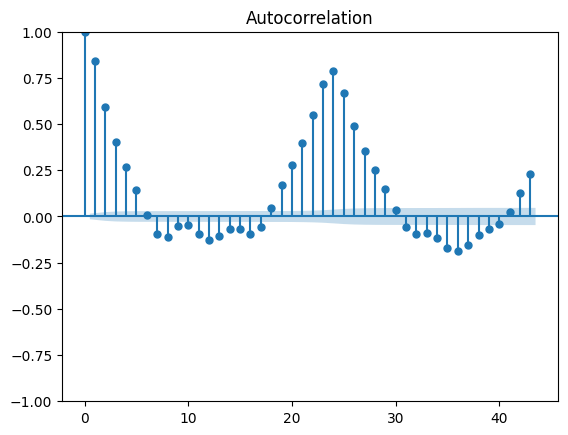

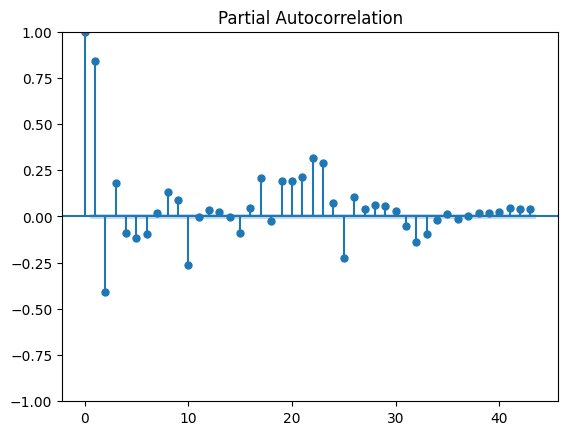

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF: dit aat zien hoe de huidige waarde afhankelijk is van eerdere waarden
plot_acf(train_data_final['cnt'])
plt.show()

# PACF: dit laat zien welke lags directe invloeden hebben
plot_pacf(train_data_final['cnt'])
plt.show()


Hier zien we een autocorrelatiefunctie (ACF) en deze geeft de correlatie tussen de tijdserie waarden meet op verschillende lags. Zodra de verticale blauwe staven de horizontale blauwe balk in het midden raken is de correlatie op deze lag niet meer significant. Je ziet dat er duidelijke pieken rond lag 20, 30, en mogelijk daarna liggen wat wijst op een herhalend patroon in de data.

In [ ]:
print(train_data_final.index.to_series().diff().value_counts())


date_hour
0 days 01:00:00    16365
0 days 02:00:00      141
0 days 03:00:00       18
0 days 13:00:00        1
0 days 23:00:00        1
0 days 07:00:00        1
0 days 14:00:00        1
0 days 04:00:00        1
1 days 13:00:00        1
Name: count, dtype: int64


In [67]:
# Zorg ervoor dat test_data ook een DatetimeIndex heeft
test_data['date_hour'] = pd.to_datetime(test_data['date_hour'])  # Converteer naar datetime
test_data.set_index('date_hour', inplace=True)  # Stel het in als index
test_data


,holiday,weathersit,temp,atemp,hum,windspeed
date_hour,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
...,...,...,...,...,...,...
2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881
2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239
2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239


In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Definieer het model
model = SARIMAX(
    train_data_final['cnt'],  # Doelvariabele
    order=(6, 0, 5),         # Niet-seizoensgebonden parameters
    seasonal_order=(2, 0, 1, 24),  # Seizoensgebonden parameters
    exog=train_data_final[['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month']],  # Exogene variabelen
    enforce_stationarity=False,  # Geen extra stationariteit forceren
    enforce_invertibility=False  # Geen extra inversie forceren
)

# Train het model
results = model.fit()

# Print de samenvatting
print(results.summary())


c:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                  cnt   No. Observations:                16531
Model:             SARIMAX(6, 0, 5)x(2, 0, [1], 24)   Log Likelihood              -93309.400
Date:                              Sun, 01 Dec 2024   AIC                         186662.801
Time:                                      21:44:37   BIC                         186832.415
Sample:                                           0   HQIC                        186718.819
                                            - 16531                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
year            0.0820      0.016      4.988      0.000       0.050       0.114
month           

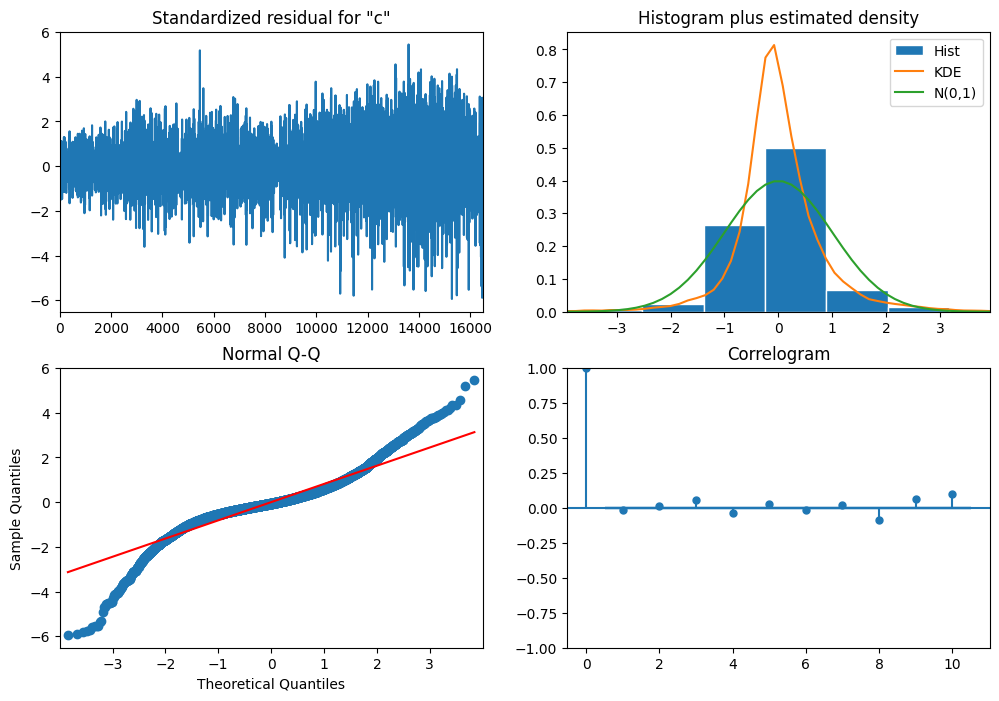

In [69]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()


### Visualisaties interpreteren en conclusies trekken

- *Linksboven:* Hier staan de gestandaardiseerde residuen (de verschillen tussen de werkelijke waarden en de voorspellingen van het model). Ze zijn verdeeld rond de nul en er zijn geen duidelijke patronen zichtbaar. Redelijk willekeurig met een paar uitschieters.
- *Rechtsboven:* Hier zie je in het groen een normaalverdeling en in het oranje de verdeling van de residuen. Als het model goed past moet deze erg op de groene lijn lijken. Dit is deels het geval aangezien ze beide  normaal verdeeld zijn, alleen heeft de oranje lijn een hogere piek. De residuen zijn dus niet perfect normaal verdeeld.
- *Linksonder:* Dit is een vergelijking van de kwantielen van de residuen met de verwachte kwantielen van een normale verdeling. De rode lijn betekent dat alles goed is verdeeld. Ook deze plot laat zien dat de residuen niet perfect normaal verdeeld zijn.
- *Rechtsonder:* Dit is een autocorrelatieplot (ACF) van de residuen, deze controleert of er correlaties zijn met vorige waarden. Uit deze plot blijkt dus dat er nauwelijks nog correlaties zijn in de residuen, omdat ze allemaal op of dichtbij de blauwe balk in het midden zitten.

### Functie voor het aananmaken van features waves

In [253]:
def create_feature_waves_with_generation(df, waves):
    """
    Maakt iteratief nieuwe dataframes met extra features in golven en genereert de features automatisch.
    
    Parameters:
    - df (pd.DataFrame): Originele dataframe met minimaal een tijdindex en 'cnt'-kolom.
    - waves (list of lists): Elke sublijst bevat de namen van features die in een golf worden toegevoegd.
    
    Returns:
    - list of pd.DataFrame: Een lijst met dataframes, elk met meer features dan het vorige.
    """
    dfs = []
    base_features = ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt']  # Basis tijdfeatures
    
    # Basis tijdgerelateerde features maken
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['cnt'] = df['cnt']  # Zorg ervoor dat de doelvariabele er nog steeds is
    current_features = base_features.copy()

    for wave in waves:
        for feature in wave:
            # Logica voor featureberekeningen
            if feature == 'is_weekend':
                df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
            elif feature == 'is_holiday':
                df['is_holiday'] = df['day_of_week'].apply(lambda x: 1 if x in [0, 1] else 0)
            elif feature == 'temp_atemp_diff':
                df['temp_atemp_diff'] = df['temp'] - df['atemp']
            elif feature == 'hum_windspeed_interaction':
                df['hum_windspeed_interaction'] = df['hum'] * df['windspeed']
            elif feature == 'temp_windspeed_interaction':
                df['temp_windspeed_interaction'] = df['temp'] * df['windspeed']
            elif feature == 'windspeed_change':
                df['windspeed_change'] = df['windspeed'] - df['windspeed'].shift(1)
        
        # Voeg de nieuwe features van deze golf toe
        current_features.extend(wave)
        temp_df = df[current_features].copy()  # Maak een nieuw dataframe met de huidige features
        dfs.append(temp_df)  # Voeg dit nieuwe dataframe toe aan de lijst
    
    return dfs




### Functie voor het trainen van SARIMAX met feature waves

In [254]:
def train_sarimax_with_waves(df, waves, target, order, seasonal_order):
    """
    Train SARIMAX modellen op meerdere feature waves en evalueer hun prestaties.
    Parameters
    ----------
    df : pandas.DataFrame
        De input dataframe met de tijdreeksgegevens.
    waves : list
        Een lijst van feature waves die gegenereerd en gebruikt worden voor training.
    target : str
        De naam van de target kolom in de dataframe.
    order : tuple
        De (p, d, q) volgorde van het model voor het aantal AR parameters, verschillen en MA parameters.
    seasonal_order : tuple
        De (P, D, Q, s) seizoensvolgorde van het model voor de seizoenscomponent.
    Returns
    -------
    results_per_wave : list van dict
        Een lijst van woordenboeken met de resultaten voor elke wave. Elk woordenboek bevat:
        - 'wave': Het wave nummer.
        - 'features': De lijst van features gebruikt in de wave.
        - 'aic': Het Akaike Information Criterion van het model.
        - 'rmse': De Root Mean Squared Error van de voorspellingen.
        - 'model': Het getrainde SARIMAX model.
    """

    df = df.asfreq('d')
    df = df.infer_objects(copy=False)
    df = df.interpolate()

    # Vul ontbrekende waarden in de targetkolom in
    df[target] = df[target].fillna(df[target].mean())

    results_per_wave = []
    
    # Genereer de dataframes met de create_feature_waves_with_generation functie
    dfs = create_feature_waves_with_generation(df.copy(), waves)
    
    for idx, wave_df in enumerate(dfs):
        print(f"Wave {idx + 1}: Training SARIMAX met features: {wave_df.columns.tolist()}")
 
        missing_data, inf_data = check_for_missing_values(wave_df, target)

        if missing_data.any() or inf_data.any():
            # Interpoleer ontbrekende waarden in de exogene variabelen
            exog_columns = [col for col in wave_df.columns if col != target]
            wave_df[exog_columns] = wave_df[exog_columns].interpolate(method='linear')
            wave_df = wave_df.fillna(method='bfill')

        # Controleer of 'cnt' kolom aanwezig is in de wave_df
        if target not in wave_df.columns:
            raise ValueError(f"{target} kolom ontbreekt in deze wave.")
        
        # Model setup
        model = SARIMAX(
            wave_df[target],
            order=order,
            seasonal_order=seasonal_order,
            exog=wave_df[[col for col in wave_df.columns if col != target]],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False)
        
        # Voorspellingen maken
        predictions = results.predict(
            start=wave_df.index[0], 
            end=wave_df.index[-1], 
            exog=wave_df[[col for col in wave_df.columns if col != target]]
        )
        
        # RMSE berekenen
        rmse = np.sqrt(mean_squared_error(wave_df[target], predictions))
        
        # Opslaan van resultaten
        results_per_wave.append({
            'wave': idx + 1,
            'features': wave_df.columns.tolist(),
            'aic': results.aic,
            'rmse': rmse,  # RMSE direct toevoegen
            'model': results
        })
    
    return results_per_wave


In [255]:
# Controleer op NaN of Inf in de exogene variabelen
def check_for_missing_values(wave_df, target):
    """
    Controleer op ontbrekende (NaN) en oneindige (Inf) waarden in de exogene variabelen van een DataFrame.

    Parameters
    ----------
    wave_df : pandas.DataFrame
        De DataFrame met de gegevens om te controleren.
    target : str
        De naam van de targetkolom die moet worden uitgesloten van de controle.

    Returns
    -------
    missing_data : pandas.Series
        Een serie met het aantal ontbrekende (NaN) waarden voor elke exogene variabele.
    inf_data : pandas.Series
        Een serie met het aantal oneindige (Inf) waarden voor elke exogene variabele.
    """
    # Zoek naar NaN en Inf waarden in de exogene variabelen
    exog_columns = [col for col in wave_df.columns if col != target]
    missing_data = wave_df[exog_columns].isnull().sum()  # Aantal NaN per kolom
    inf_data = (wave_df[exog_columns] == float('inf')).sum()  # Aantal Inf per kolom
    if missing_data.any() or inf_data.any():
        print(f"Waarschuwing: Er zijn ontbrekende (NaN) of oneindige (Inf) waarden in de exogene variabelen.")
        print(f"Ontbrekende waarden per kolom:\n{missing_data}")
        print(f"Oneindige waarden per kolom:\n{inf_data}")
    return missing_data, inf_data


### Trainen SARIMAX

In [256]:
# Waves configureren
waves = [
    ['is_weekend', 'is_holiday'],  # Wave 1: Weekend en feestdagen
    ['temp_atemp_diff', 'hum_windspeed_interaction'],  # Wave 2: Interacties
    ['temp_windspeed_interaction', 'windspeed_change']  # Wave 3: Complexere interacties
]

# SARIMA-parameters instellen
order = (2, 0, 1)
seasonal_order = (2, 0, 1, 24)  # Uurlijkse data met een dagelijkse seizoenscyclus

# Train modellen per wave
results = train_sarimax_with_waves(
    df=train_data_final,  # Originele dataset
    waves=waves,
    target='cnt',
    order=order,
    seasonal_order=seasonal_order
)

# Resultaten bekijken
for result in results:
    print(f"Wave {result['wave']}:")
    print(f"AIC: {result['aic']}")
    print(f"RMSE: {result['rmse']}")
    print(f"Features: {result['features']}")
    # print(result['summary'])


Wave 1: Training SARIMAX met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday']


c:\Users\USER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wave 2: Training SARIMAX met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction']


c:\Users\USER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wave 3: Training SARIMAX met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction', 'temp_windspeed_interaction', 'windspeed_change']
Waarschuwing: Er zijn ontbrekende (NaN) of oneindige (Inf) waarden in de exogene variabelen.
Ontbrekende waarden per kolom:
year                          0
month                         0
day                           0
day_of_week                   0
quarter                       0
sin_month                     0
cos_month                     0
is_weekend                    0
is_holiday                    0
temp_atemp_diff               0
hum_windspeed_interaction     0
temp_windspeed_interaction    0
windspeed_change              1
dtype: int64
Oneindige waarden per kolom:
year                          0
month                         0
day                           0
day_of_week                   0
quarter                       0
sin_month

C:\Users\USER\AppData\Local\Temp\ipykernel_38816\58683726.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wave_df = wave_df.fillna(method='bfill')
c:\Users\USER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wave 1:
AIC: 6095.511643996524
RMSE: 25.97774582068865
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday']
Wave 2:
AIC: 6112.168055261273
RMSE: 25.878140148802604
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction']
Wave 3:
AIC: 6119.7771164462265
RMSE: 25.77327269911747
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction', 'temp_windspeed_interaction', 'windspeed_change']


In [257]:
test_data = pd.read_csv('test.csv')
test_data['date_hour'] = pd.to_datetime(test_data['date_hour'])
test_data.set_index('date_hour', inplace=True)

test_data['year'] = test_data.index.year
test_data['month'] = test_data.index.month
test_data['day'] = test_data.index.day
test_data['day_of_week'] = test_data.index.dayofweek
test_data['quarter'] = test_data.index.quarter

test_data['sin_month'] = np.sin(2 * np.pi * test_data['month'] / 12)
test_data['cos_month'] = np.cos(2 * np.pi * test_data['month'] / 12)

test_data['is_weekend'] = test_data['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
test_data['temp_atemp_diff'] = test_data['temp'] - test_data['atemp']
test_data['hum_windspeed_interaction'] = test_data['hum'] * test_data['windspeed']
test_data['is_holiday'] = test_data['day_of_week'].apply(lambda x: 1 if x in [0, 1] else 0)

In [258]:
# Zoek het resultaat met de laagste RMSE
best_result = min(results, key=lambda x: x['rmse'])

# Verkrijg het model
best_model = best_result['model']

# Bekijk details van het beste model
print(f"Beste Model: Wave {best_result['wave']}")
print(f"Features: {best_result['features']}")
print(f"AIC: {best_result['aic']}")
print(f"RMSE: {best_result['rmse']}")


Beste Model: Wave 3
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction', 'temp_windspeed_interaction', 'windspeed_change']
AIC: 6119.7771164462265
RMSE: 25.77327269911747


In [170]:
test_data = pd.read_csv('test.csv')

if 'cnt' in test_data.columns:
    test_data_final = test_data.drop(columns=['cnt']).copy()
else:
    test_data_final = test_data.copy()

# Controleer of de 'date_hour' kolom een datetime is
test_data_final['date_hour'] = pd.to_datetime(test_data_final['date_hour'])

# Stel de 'date_hour' kolom in als de index
test_data_final.set_index('date_hour', inplace=True)

# Zorg ervoor dat de tijdindex correct is
test_data_final = test_data_final.asfreq('d')

# Interpoleer eventuele missende waarden
test_data_final = test_data_final.infer_objects(copy=False)
test_data_final = test_data_final.interpolate()

# Tijdgerelateerde features toevoegen
test_data_final['year'] = test_data_final.index.year
test_data_final['month'] = test_data_final.index.month
test_data_final['day'] = test_data_final.index.day
test_data_final['day_of_week'] = test_data_final.index.dayofweek
test_data_final['quarter'] = test_data_final.index.quarter
test_data_final['sin_month'] = np.sin(2 * np.pi * test_data_final['month'] / 12)
test_data_final['cos_month'] = np.cos(2 * np.pi * test_data_final['month'] / 12)
test_data_final['is_weekend'] = test_data_final['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
test_data_final['is_holiday'] = test_data_final['day_of_week'].apply(lambda x: 1 if x in [0, 1] else 0)
test_data_final['temp_atemp_diff'] = test_data_final['temp'] - test_data_final['atemp']
test_data_final['hum_windspeed_interaction'] = test_data_final['hum'] * test_data_final['windspeed']
test_data_final['temp_windspeed_interaction'] = test_data_final['temp'] * test_data_final['windspeed']
test_data_final['windspeed_change'] = test_data_final['windspeed'] - test_data_final['windspeed'].shift(1)

# Beste features van het model
best_result = min(results, key=lambda x: x['rmse'])
best_features = best_result['features']

if 'cnt' in best_features:
    best_features.remove('cnt')

# De exogene variabelen instellen
test_data_final_exog = test_data_final[best_features]
test_data_final_exog = test_data_final_exog.fillna(method='bfill')

# Haal het beste model op
best_model = best_result['model']

# Voorspellen
predictions = best_model.predict(start=test_data_final_exog.index[0], 
                                    end=test_data_final_exog.index[-1], 
                                    exog=test_data_final_exog)


C:\Users\USER\AppData\Local\Temp\ipykernel_38816\2206180087.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data_final_exog = test_data_final_exog.fillna(method='bfill')


## Prophet

- **Wat is een Prophet model?**

    Het prophet model is een voorspellingsmodel speciaal voor tijdseries en maakt robuuste en eenvoudige voorspellingen op data met seizoensgebonden patronen.

- **Hoe werkt een Prophet model?**

    Het prophet model kan de belangrijkste features van de data scheiden, zodat deze afzonderlijk van elkaar geanalyseerd kunnen worden.
    Eerst wordt de data opgesplitst in vier delen:

    - *Trend:* Hier wordt gekeken hoe de data over de tijd verandert.
    - *Seizoenspatronen:* Hier wordt gekeken naar patronen die vast staan in tijd. Denk hierbij aan dag/nacht cyclus of patronen die zich iedere week, maand of zelfs jaar herhalen.
    - *Specifieke gebeurtenissen:* Hier wordt gekeken naar bijvoorbeeld feestdagen rond kerst of pasen, omdat er rond deze tijden promoties of acties plaats kunnen vinden.
    - *Onverklaarbare ruis:* De data die overblijft wordt gezien als onverklaarbare ruis, omdat hier geen patroon in herkend kan worden.

    Vervolgens worden deze onafhankelijk van de rest geschat en er wordt gekeken naar de knikpunten. Hierbij wordt gekeken naar de plotselinge trendveranderingen, neem als voorbeeld als de verhuuraantallen ineens verdubbelen. 
    
    Daarna wordt er gekeken naar de seizoenspatronen met de fourier-series. De specifieke gebeurtenissen worden vervolgens ook in het model verwerkt om zo de voorspellingen mogelijk te verbeteren. Er worden daarna schattingen gedaan naar de parameters om zo de fouten te minimaliseren. Als alle componenten zijn geschat worden de toekomstige waarden voorspelt.

OpenAi. (2024, 1 december). https://chatgpt.com/share/e/674cd1ec-33bc-8005-a740-32ec88754a49

Taylor, SJ. Letham, P. (2017, 23 februari). Prophet: forecasting at scale. https://research.facebook.com/blog/2017/2/prophet-forecasting-at-scale/

In [218]:
df_prophet = train_data_cleaned.copy()
df_prophet.reset_index(inplace=True)

# Hernoemen van de kolommen naar Prophet's formaat
df_prophet = df_prophet.rename(columns={'cnt': 'y'})
df_prophet = df_prophet.rename(columns={'date_hour': 'ds'})


In [221]:
!pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/12/ff/a04156f4ca3d18bd005c73f79e86e0684346fbc2aea856429c3e49f2828e/prophet-1.1.6-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/5d/12/6522f3de83ca690aa52f4b8c88a1e203abb1e2d75c31669dc004949143cd/cmdstanpy-1.2.4-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/5c/bb/2fdb6903d5c8650a980bfc308831d0710485d01b448bb124e23fb57ece3f/holidays-0.61-py3-none-any.whl.metadata
  Using cached holidays-0.61-py3-none-any.whl.metadata (26 kB)
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/e1/6a/4604f9ae2fa62ef47b9de2fa5ad599589d28c9fd1d335f32759813dfa91e/importlib_resources-6.4.5-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhoste

In [232]:
# Stel een Prophet-model op met regressoren
from prophet import Prophet
from sklearn.metrics import mean_squared_error

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Toevoegen van regressoren
model.add_regressor('holiday')
model.add_regressor('weathersit')
model.add_regressor('temp')
model.add_regressor('atemp')
model.add_regressor('hum')
model.add_regressor('windspeed')

# Trainen van het model
ph = model.fit(df_prophet)
# Maak voorspellingen
future = model.make_future_dataframe(periods=456, freq='H')
future = future.merge(df_prophet.drop(columns=['y']), on='ds', how='left')

# Vul eventuele ontbrekende waarden in de regressoren in
future[['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']] = future[['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']].fillna(method='ffill').fillna(method='bfill')

forecast = model.predict(future)

# Bereken RMSE
rmse_ph = mean_squared_error(df_prophet['y'], forecast.loc[:len(df_prophet)-1, 'yhat'], squared=False)
print(f'RMSE: {rmse_ph}')

23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\USER\AppData\Local\Temp\ipykernel_38816\3217905050.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future[['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']] = future[['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']].fillna(method='ffill').fillna(method='bfill')


RMSE: 146.75442267893257


In [223]:
future = model.make_future_dataframe(periods=30, freq='h')
future

,ds
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00
...,...
16556,2012-12-02 01:00:00
16557,2012-12-02 02:00:00
16558,2012-12-02 03:00:00
16559,2012-12-02 04:00:00


In [224]:
# Maak een DataFrame met toekomstige datums (bijv. 30 uur vooruit)
future = model.make_future_dataframe(periods=30, freq='h')  # 'H' voor uur
future = future.merge(df_prophet[['ds', 'holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']], on='ds', how='left')
for col in ['temp', 'atemp', 'hum', 'windspeed']:
    future[col].fillna(df_prophet[col].mean(), inplace=True)
for col in ['holiday', 'weathersit']:
    future[col].fillna(df_prophet[col].mode()[0], inplace=True)

# Controleer de toekomstige data
print(future.tail())


                       ds  holiday  weathersit      temp     atemp       hum  \
16556 2012-12-02 01:00:00      0.0         1.0  0.505204  0.482984  0.623953   
16557 2012-12-02 02:00:00      0.0         1.0  0.505204  0.482984  0.623953   
16558 2012-12-02 03:00:00      0.0         1.0  0.505204  0.482984  0.623953   
16559 2012-12-02 04:00:00      0.0         1.0  0.505204  0.482984  0.623953   
16560 2012-12-02 05:00:00      0.0         1.0  0.505204  0.482984  0.623953   

       windspeed  
16556   0.190742  
16557   0.190742  
16558   0.190742  
16559   0.190742  
16560   0.190742  


In [225]:
# Maak voorspellingen
forecast = model.predict(future)

# Bekijk de voorspellingen
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


                       ds        yhat  yhat_lower  yhat_upper
0     2011-01-01 00:00:00  -34.441966 -238.574974  149.531551
1     2011-01-01 01:00:00  -42.597330 -222.589450  141.961914
2     2011-01-01 02:00:00  -42.442800 -228.732225  154.257660
3     2011-01-01 03:00:00  -18.025500 -191.397280  174.710493
4     2011-01-01 04:00:00  -17.886960 -205.774900  151.640847
...                   ...         ...         ...         ...
16556 2012-12-02 01:00:00  320.359901  131.911773  515.205111
16557 2012-12-02 02:00:00  320.200747  147.035662  505.295588
16558 2012-12-02 03:00:00  320.021079  133.713956  504.481147
16559 2012-12-02 04:00:00  319.821767  141.797754  505.008708
16560 2012-12-02 05:00:00  319.603876  125.350829  507.913113

[16561 rows x 4 columns]


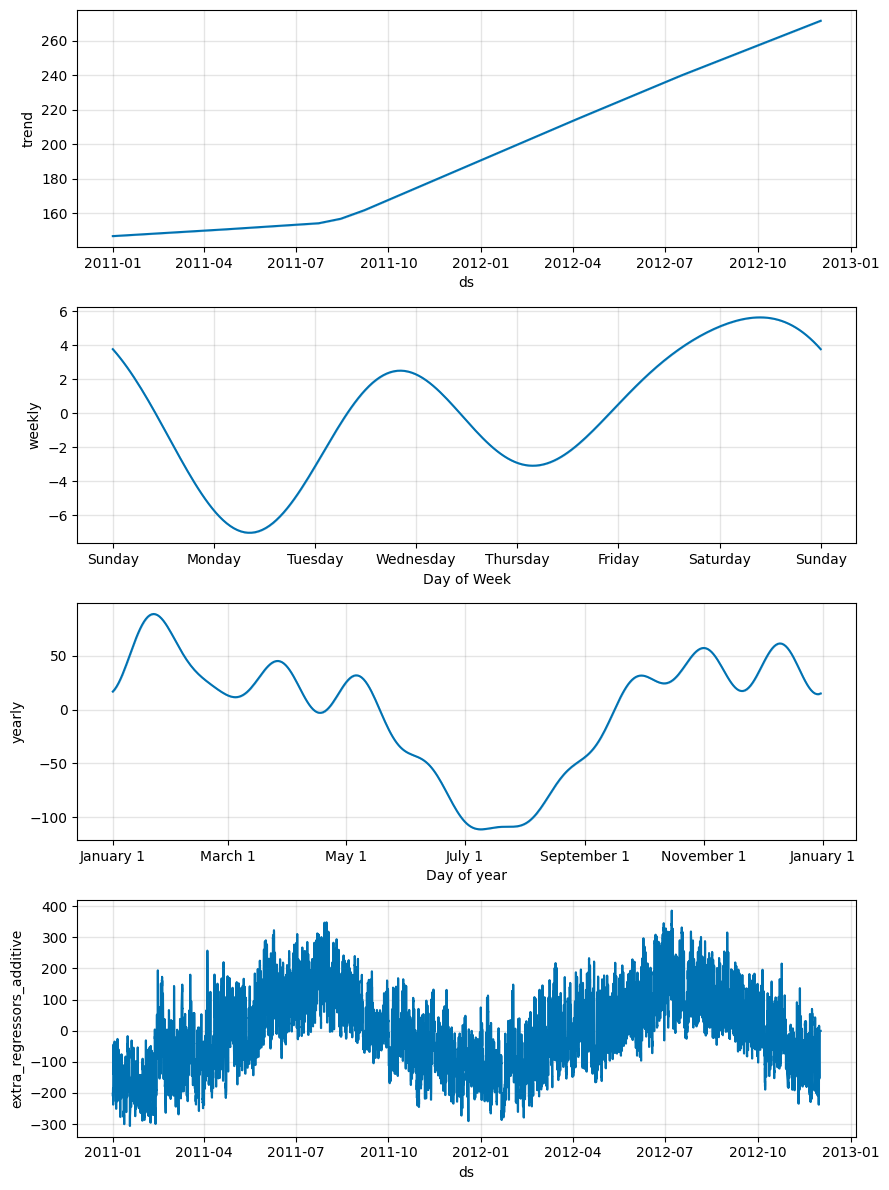

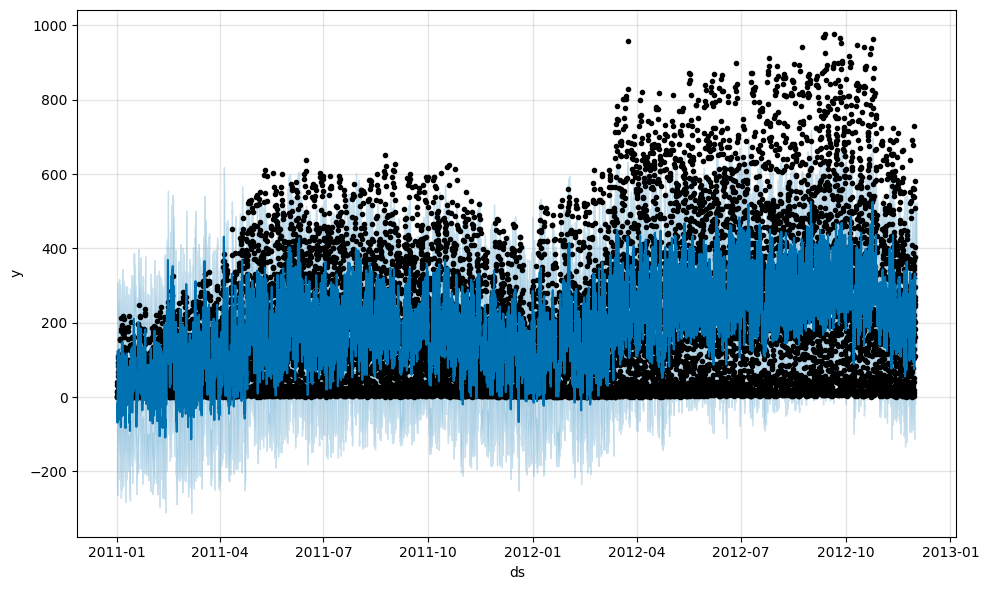

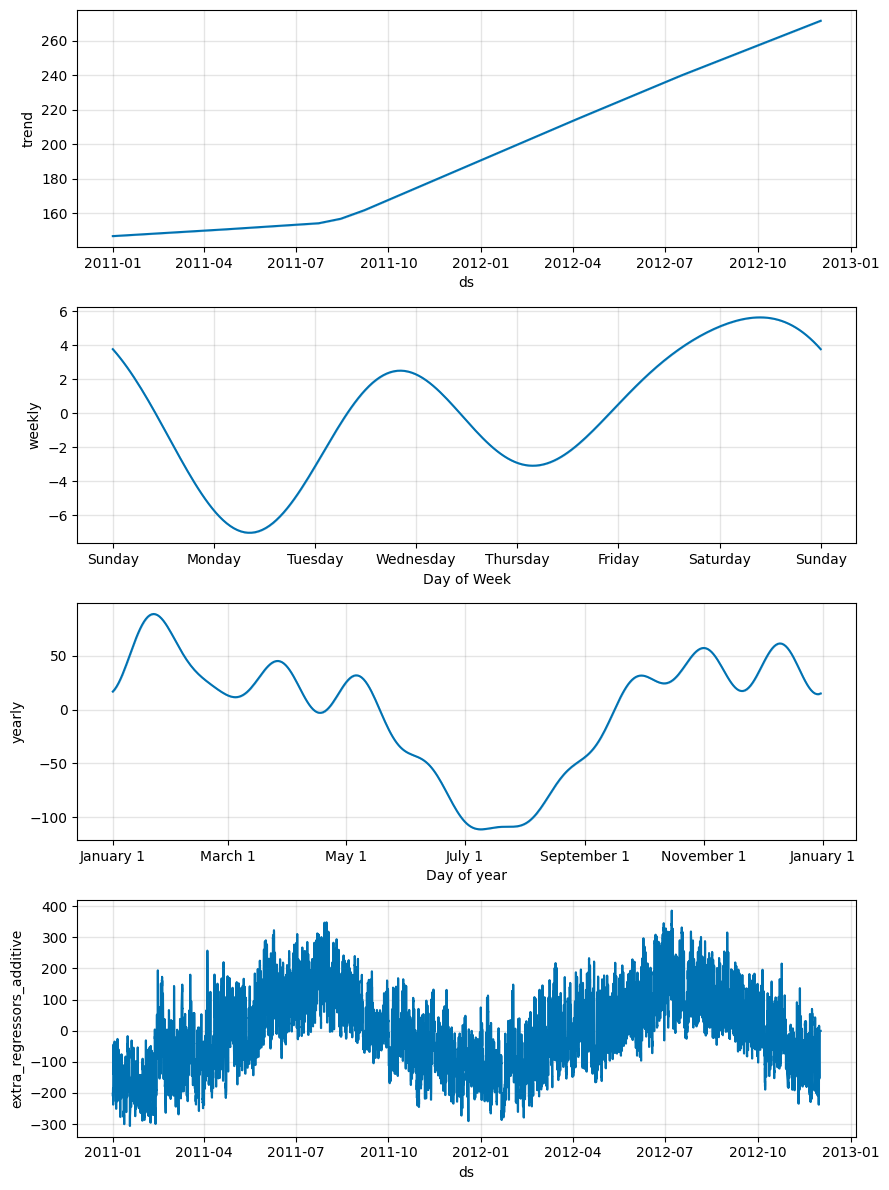

In [226]:
# Voorspellingen plotten
model.plot(forecast)

# Componenten bekijken
model.plot_components(forecast)


In [227]:
# Zorg ervoor dat 'test_data' een kolom 'ds' bevat
# Voeg eventuele regressoren toe aan 'test_data', net als bij de future DataFrame
# Hernoem de 'date_hour' kolom naar 'ds' zodat Prophet het herkent
test_data = pd.read_csv('test.csv')
test_data['date_hour'] = pd.to_datetime(test_data['date_hour'])
test_data = test_data.rename(columns={'date_hour': 'ds'})
test_data = test_data.merge(df_prophet[['ds', 'holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']], on='ds', how='left')

# Behoud alleen de correcte versies (de '_x'-kolommen)
test_data = test_data[['ds', 'holiday_x', 'weathersit_x', 'temp_x', 'atemp_x', 'hum_x', 'windspeed_x']]

# Hernoem de '_x'-kolommen naar hun oorspronkelijke namen
test_data.rename(columns={
    'holiday_x': 'holiday',
    'weathersit_x': 'weathersit',
    'temp_x': 'temp',
    'atemp_x': 'atemp',
    'hum_x': 'hum',
    'windspeed_x': 'windspeed'
}, inplace=True)

# Vul ontbrekende waarden in
test_data['holiday'].fillna(0, inplace=True)
test_data['weathersit'].fillna(df_prophet['weathersit'].mode()[0], inplace=True)
test_data['temp'].fillna(df_prophet['temp'].mean(), inplace=True)
test_data['atemp'].fillna(df_prophet['atemp'].mean(), inplace=True)
test_data['hum'].fillna(df_prophet['hum'].mean(), inplace=True)
test_data['windspeed'].fillna(df_prophet['windspeed'].mean(), inplace=True)

# Maak voorspellingen
forecast = model.predict(test_data)

# Voeg 'yhat' (voorspelde waarden) toe aan test_data
test_data['yhat'] = forecast['yhat']


## Hybrid (waves)

In [239]:
def train_hybrid_with_waves(df, waves, target):
    """
    Trains a hybrid model (Linear Regression + Decision Tree) iteratively for each wave of features and calculates RMSE.
    """
    results_per_wave = []

    # Aanmaken van de dataframes met de create_feature_waves_with_generation functie
    dfs = create_feature_waves_with_generation(df.copy(), waves)
    
    for idx, wave_df in enumerate(dfs):
        print(f"Wave {idx + 1}: Training hybride model met features: {wave_df.columns.tolist()}")

        # Data splitsen
        X = wave_df.drop(columns=[target]).fillna(method='bfill')
        y = wave_df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7*24, shuffle=False)
        
        # Eerste model (Lineaire Regressie)
        model1 = LinearRegression()
        model1.fit(X_train, y_train)
        train_predict1 = model1.predict(X_train)
        test_predict1 = model1.predict(X_test)
        
        # Residuen berekenen
        y_train_res = y_train - train_predict1
        y_test_res = y_test - test_predict1

        # Tweede model (Decision Tree met GridSearchCV)
        param_grid = {
            'max_depth': [3, 5, 10, 15],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [1, 2, 4, 6]
        }
        grid_search = GridSearchCV(
            DecisionTreeRegressor(),
            param_grid,
            cv=TimeSeriesSplit(n_splits=5),
            scoring='neg_mean_squared_error'
        )
        grid_search.fit(X_train, y_train_res)

        # Beste model selecteren en trainen
        model2 = grid_search.best_estimator_
        model2.fit(X_train, y_train_res)

        # Totale voorspellingen maken
        train_predictions_total = train_predict1 + model2.predict(X_train)
        test_predictions_total = test_predict1 + model2.predict(X_test)

        # RMSE berekenen
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions_total))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions_total))
        
        # Opslaan van resultaten
        results_per_wave.append({
            'wave': idx + 1,
            'features': wave_df.columns.tolist(),
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'best_params': grid_search.best_params_,
            'model1': model1,
            'model2': model2
        })
        
        print(f"Wave {idx + 1}: Train RMSE={train_rmse:.2f}, Test RMSE={test_rmse:.2f}, Best Params={grid_search.best_params_}")

    return results_per_wave


# Waves aanmaken
waves = [
    ['is_weekend', 'is_holiday'],  # Wave 1
    ['temp_atemp_diff', 'hum_windspeed_interaction'],  # Wave 2
    ['temp_windspeed_interaction', 'windspeed_change']  # Wave 3
]

# Hybride model per wave trainen
results = train_hybrid_with_waves(
    df=train_data_cleaned,
    waves=waves,
    target='cnt'
)

# Resultaten bekijken
for result in results:
    print(f"Wave {result['wave']}:")
    print(f"Train RMSE: {result['train_rmse']:.2f}, Test RMSE: {result['test_rmse']:.2f}")
    print(f"Features: {result['features']}")
    print(f"Beste hyperparameters voor Decision Tree: {result['best_params']}")


Wave 1: Training hybride model met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday']


C:\Users\USER\AppData\Local\Temp\ipykernel_38816\3751431623.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = wave_df.drop(columns=[target]).fillna(method='bfill')


Wave 1: Train RMSE=167.90, Test RMSE=165.17, Best Params={'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
Wave 2: Training hybride model met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction']


C:\Users\USER\AppData\Local\Temp\ipykernel_38816\3751431623.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = wave_df.drop(columns=[target]).fillna(method='bfill')


Wave 2: Train RMSE=164.57, Test RMSE=170.87, Best Params={'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 15}
Wave 3: Training hybride model met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction', 'temp_windspeed_interaction', 'windspeed_change']


C:\Users\USER\AppData\Local\Temp\ipykernel_38816\3751431623.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = wave_df.drop(columns=[target]).fillna(method='bfill')


Wave 3: Train RMSE=152.67, Test RMSE=170.62, Best Params={'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 10}
Wave 1:
Train RMSE: 167.90, Test RMSE: 165.17
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday']
Beste hyperparameters voor Decision Tree: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
Wave 2:
Train RMSE: 164.57, Test RMSE: 170.87
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction']
Beste hyperparameters voor Decision Tree: {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 15}
Wave 3:
Train RMSE: 152.67, Test RMSE: 170.62
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction', 'temp_windspeed_interaction', 'windspeed_change']
Beste hyperpara

## Hybride model

- **Hoe werkt een hybride model?**

    Een hybride model is een model dat bestaat uit meerdere modellen. Elk manchine learning model heeft zijn sterke en zwakke punten. Een hybride model combineert de sterke punten van de modellen om zo de beste voorspelling te maken.

    Om de werking van een hybride model goed te snappen wordt deze hier stapsgewijs uitgelegd.

    1. Een model doet de eerste voorspelling. Een willekeurig model wordt gekozen om de eerste voorspelling te doen en simpele patronen in de dataset te vinden en te voorspellen.

    2. Het tweede model corrigeerd de foute voorspellingen. Een tweede model wordt gebruikt om de fouten van het eerste model (ookwel residuen genoemd) te herkennen en te verbeteren waar mogelijk.

    3. De uiteindelijke voorspelling van het hybride model is zo dus een combinatie van de voorspellingen van het eerste model en de verbeteringen die het tweede model heeft gedaan. 


In [240]:
train_data_hybrid = train_data_cleaned.copy()

train_data_hybrid['year'] = train_data_hybrid.index.year
train_data_hybrid['month'] = train_data_hybrid.index.month
train_data_hybrid['day'] = train_data_hybrid.index.day
train_data_hybrid['day_of_week'] = train_data_hybrid.index.dayofweek
train_data_hybrid['quarter'] = train_data_hybrid.index.quarter
train_data_hybrid['sin_month'] = np.sin(2 * np.pi * train_data_hybrid['month'] / 12)
train_data_hybrid['cos_month'] = np.cos(2 * np.pi * train_data_hybrid['month'] / 12)
train_data_hybrid['sin_day_of_week'] = np.sin(2 * np.pi * train_data_hybrid['day_of_week'] / 7)
train_data_hybrid['cos_day_of_week'] = np.cos(2 * np.pi * train_data_hybrid['day_of_week'] / 7)

# Selecteren van features en target
X = train_data_hybrid.drop(columns=['cnt'])
y = train_data_hybrid['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7*24, shuffle=False)

# Eerste model (Lineaire Regressie)
model1 = LinearRegression()
model1.fit(X_train, y_train)
train_predict1 = model1.predict(X_train)
test_predict1 = model1.predict(X_test)

# Residuen berekenen
y_train_res = y_train - train_predict1
y_test_res = y_test - test_predict1

# Tweede model (Decision Tree met GridSearchCV)
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=TimeSeriesSplit(n_splits=10), scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_res)
model2 = grid_search.best_estimator_
model2.fit(X_train, y_train_res)

# Totale voorspellingen
train_predictions_total = train_predict1 + model2.predict(X_train)
test_predictions_total = test_predict1 + model2.predict(X_test)

print(f'{grid_search.best_params_}')
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, train_predictions_total)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, test_predictions_total)))


{'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 5}
Train RMSE: 148.14375012875962
Test RMSE: 166.32282854052437


## Kaggle submission functie

In [207]:
# Aanmaken van submissionfucntie
def kaggle_submission(model, test_data, wedstrijdnaam,
                     bestandsnaam="submission.csv", bericht="Model submission"):
    """
    Maakt en levert een submission bestand in voor Kaggle.

    Parameters:
    - model: het getrainde model dat wordt gebruikt voor voorspellingen.
    - test_data: Pandas DataFrame met de testdata van Kaggle.
    - kolommen_verwijderen: Lijst met kolommen die uit de testdata verwijderd moeten worden.
    - scaler: Een scaler object (bijv. StandardScaler of MinMaxScaler) om de testdata te schalen.
    - wedstrijdnaam: Naam van de Kaggle competitie.
    - bestandsnaam: Naam van het output submissionbestand (standaard: "submission.csv").
    - bericht: Bericht dat meegestuurd wordt bij het indienen (standaard: "Model submission").

    Returns:
    - Geen, maar slaat een bestand op en dient het in via de kaggle API.
    """

    # Maken van voorspellingen
    y_pred_kaggle = model.predict(test_data)

    # Aanmaken van submission DataFrame
    submission = pd.DataFrame({
        'date_hour': test_data.index,
        'cnt': y_pred_kaggle.flatten()
        })
    
    # Oplsaan van submissionbestand
    submission.to_csv(bestandsnaam, index=False)
    print(f"Submissionbestand {bestandsnaam} succesvol opgeslagen.")
    
    # Indienen via de Kaggle API
    os.system(f'kaggle competitions submit -c {wedstrijdnaam} -f {bestandsnaam} -m "{bericht}"')
    print(f"Submission ingediend voor wedstrijd: {wedstrijdnaam}.")

### Kaggle hybrid submission functie

In [241]:
# Aanmaken van submissionfucntie voor hybride model
def kaggle_submission_hybrid(model, test_data, wedstrijdnaam, 
                      bestandsnaam="submission.csv", bericht="Model submission", 
                      hybrid=False, model2=None, prophet=False):
    """
    Maakt en levert een submission bestand in voor Kaggle.

    Parameters:
    - model: Het eerste getrainde model (bijvoorbeeld een lineaire regressie).
    - test_data: Pandas DataFrame met de testdata van Kaggle.
    - wedstrijdnaam: Naam van de Kaggle competitie.
    - bestandsnaam: Naam van het output submissionbestand (standaard: "submission.csv").
    - bericht: Bericht dat meegestuurd wordt bij het indienen (standaard: "Model submission").
    - hybrid: Boolean, geeft aan of een hybride model wordt gebruikt (standaard: False).
    - model2: Het tweede model dat wordt gebruikt bij een hybride model (standaard: None).

    Returns:
    - Geen, maar slaat een bestand op en dient het in via de Kaggle API.
    """

    if hybrid:
        # Hybride model: gebruik zowel model1 als model2
        if model2 is None:
            raise ValueError("Voor een hybride model moet model2 worden opgegeven.")
        
        # Voorspellingen van het eerste model
        pred1 = model.predict(test_data)

        # Voorspellingen van het tweede model
        pred2 = model2.predict(test_data)

        # Combineren van de voorspellingen
        y_pred_kaggle = pred1 + pred2


    elif prophet:
        submission = pd.DataFrame({
            'date_hour': test_data['ds'],
            'cnt': forecast['yhat']
            })
    
    else:
        # Enkelvoudig model
        y_pred_kaggle = model.predict(test_data)

    # Aanmaken van submission DataFrame
    submission = pd.DataFrame({
        'date_hour': test_data.index,
        'cnt': y_pred_kaggle.flatten()
    })

    # Oplsaan van submissionbestand
    submission.to_csv(bestandsnaam, index=False)
    print(f"Submissionbestand {bestandsnaam} succesvol opgeslagen.")
    
    # Indienen via de Kaggle API
    os.system(f'kaggle competitions submit -c {wedstrijdnaam} -f {bestandsnaam} -m "{bericht}"')
    print(f"Submission ingediend voor wedstrijd: {wedstrijdnaam}.")


# Opdracht 3: Bevindingen

**Resultaten regression modellen voor en na toevoegen tijdsfeatures**

In [234]:
display(wow3.scores_df)
display(wow4.scores_df)

,Model,Score
0,lr,129.799524
1,knn,189.080307
2,rf,101.037531
3,gb,100.493032
4,dt,103.326755


,Model,Score
0,lr,10.623427
1,knn,101.453344
2,rf,38.393337
3,gb,31.236722
4,dt,42.786815


**resultaat SARIMAX**

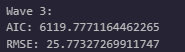

**Resultaat prophet**

In [248]:
print('RMSE prophet:', rmse_ph)

RMSE prophet: 146.75442267893257


**Resultaat hybride model**

In [249]:
print('RMSE hybride model:', np.sqrt(mean_squared_error(y_test, test_predictions_total)))

RMSE hybride model: 166.32282854052437


Uit onze resultaten blijk dat *Lineair regression* de beste RMSE heeft. Dit model heeft geen hyperparameters.

# Opdracht 4: Conclusie en aanbevelingen

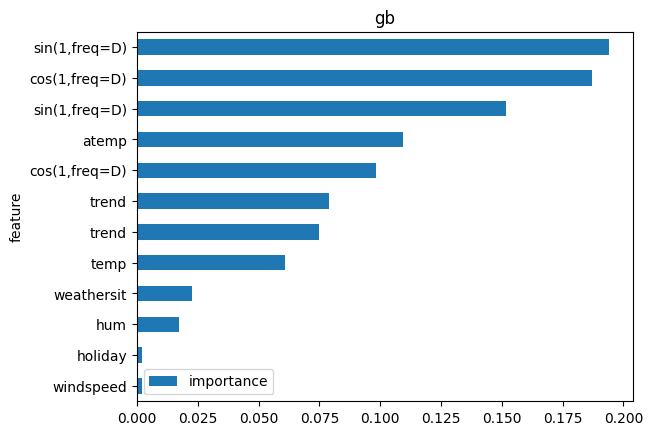

In [244]:
wow3.show_feature_importances()

In [246]:
wow4.show_feature_importances()

## Conclusies

Uit de resultaten blijkt dat hoe meer features er geimplementeerd werden in de data hoe beter de modellen presteerde. Wij hebben hier de volgende features voor gebruikt: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt', 'is_weekend', 'is_holiday']. Hierboven worden de feature importances weergeven in een visualisatie.

Het komt redelijk overeen me de EDA, aangezien waar hier ook omschreven hebben dat de weersomstandigheden en temperatuur een grote rol spelen en dat er een duidelijk seizoenspatroon in zit.

Wij adviseren goed te kijken naar de weersomstandigheden zoals regen of temperatuur, dit kan een grote invloed hebben op de verhuuraantallen. Ook is het belangrijk om de dagen van het jaar te analyseren zodat het aanbod aangepast kan worden op de vraag van bijvoorbeeld feestdagen.

Wij adviseren Lineair regression als beste model, omdat wij bij dit model de laagste fout terug kregen. Een lage fout is belangrijk als het gaat om het voorspellen met tijdsdata.

## 

## **Bronnenlijst**
- OpenAI. (2024, 29 november). https://chatgpt.com/share/e/674b33d3-a97c-8005-a780-d15b31ab046f
- OpenAI. (2024, 30 november). https://chatgpt.com/share/e/674b390c-d89c-8005-83b3-b04e65ebb7b9
- DecisionTreeRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- GeeksforGeeks. (2024, October 23). Linear Regression in Machine learning. GeeksforGeeks. https://www.geeksforgeeks.org/ml-linear-regression/
- GradientBoostingClassifier. (z.d.). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- RandomForestRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- OpenAI. (2024, 1 december). https://chatgpt.com/share/e/674cc388-3374-8005-bb6e-ad05225c3486 
- OpenAi. (2024, 1 december). https://chatgpt.com/share/e/674cd1ec-33bc-8005-a740-32ec88754a49
- Taylor, SJ. Letham, P. (2017, 23 februari). Prophet: forecasting at scale. https://research.facebook.com/blog/2017/2/prophet-forecasting-at-scale/